In [157]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler

In [158]:
# load dataset
with open("C:/Users/Stille/Desktop/ML projects/zhengqi_train.txt")  as fr:
    data_train = pd.read_table(fr, sep = "\t")
with open("C:/Users/Stille/Desktop/ML projects/zhengqi_test.txt") as fr_test:
    data_test = pd.read_table(fr_test, sep = "\t")

In [159]:
# merge training set and testing set
data_train["origin"] = "train"
data_test["origin"] = "test"
data_all=pd.concat([data_train,data_test], axis = 0, ignore_index = True)

In [160]:
data_all.drop(["V5","V9","V11","V17","V22","V28"], axis = 1, inplace = True)

In [161]:
# normalize numeric columns
cols_numeric = list(data_all.columns)
cols_numeric.remove("origin")
def scale_minmax(col):
    return (col - col.min()) / (col.max() - col.min())
scale_cols = [col for col in cols_numeric if col != 'target']
data_all[scale_cols] = data_all[scale_cols].apply(scale_minmax, axis = 0)

In [162]:
data_all.describe()

V0           V1           V2           V3           V4  \
count  4813.000000  4813.000000  4813.000000  4813.000000  4813.000000   
mean      0.694172     0.721357     0.602300     0.603139     0.523743   
std       0.144198     0.131443     0.140628     0.152462     0.106430   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.626676     0.679416     0.514414     0.503888     0.478182   
50%       0.729488     0.752497     0.617072     0.614270     0.535866   
75%       0.790195     0.799553     0.700464     0.710474     0.585036   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                V6           V7           V8          V10          V12  ...  \
count  4813.000000  4813.000000  4813.000000  4813.000000  4813.000000  ...   
mean      0.748823     0.745740     0.715607     0.348518     0.578507  ...   
std       0.132560     0.132577     0.118105     0.134882     0.105088  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.683324     0.696938     0.664934     0.284327     0.532892  ...   
50%       0.774125     0.771974     0.742884     0.366469     0.591635  ...   
75%       0.842259     0.836405     0.790835     0.432965     0.641971  ...   
max       1.000000     1.000000     1.000000     1.000000     1.000000  ...   

               V29          V30          V31          V32          V33  \
count  4813.000000  4813.000000  4813.000000  4813.000000  4813.000000   
mean      0.388683     0.589459     0.792709     0.628824     0.458493   
std       0.133475     0.130786     0.102976     0.155003     0.099095   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.292445     0.550092     0.761816     0.562461     0.409037   
50%       0.375734     0.594428     0.815055     0.643056     0.454518   
75%       0.471837     0.650798     0.852229     0.719777     0.500000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               V34          V35          V36          V37       target  
count  4813.000000  4813.000000  4813.000000  4813.000000  2888.000000  
mean      0.483790     0.762873     0.332385     0.545795     0.126353  
std       0.101020     0.102037     0.127456     0.150356     0.983966  
min       0.000000     0.000000     0.000000     0.000000    -3.044000  
25%       0.454490     0.727273     0.270584     0.445647    -0.350250  
50%       0.499949     0.800020     0.347056     0.539317     0.313000  
75%       0.511365     0.800020     0.414861     0.643061     0.793250  
max       1.000000     1.000000     1.000000     1.000000     2.538000  

[8 rows x 33 columns]

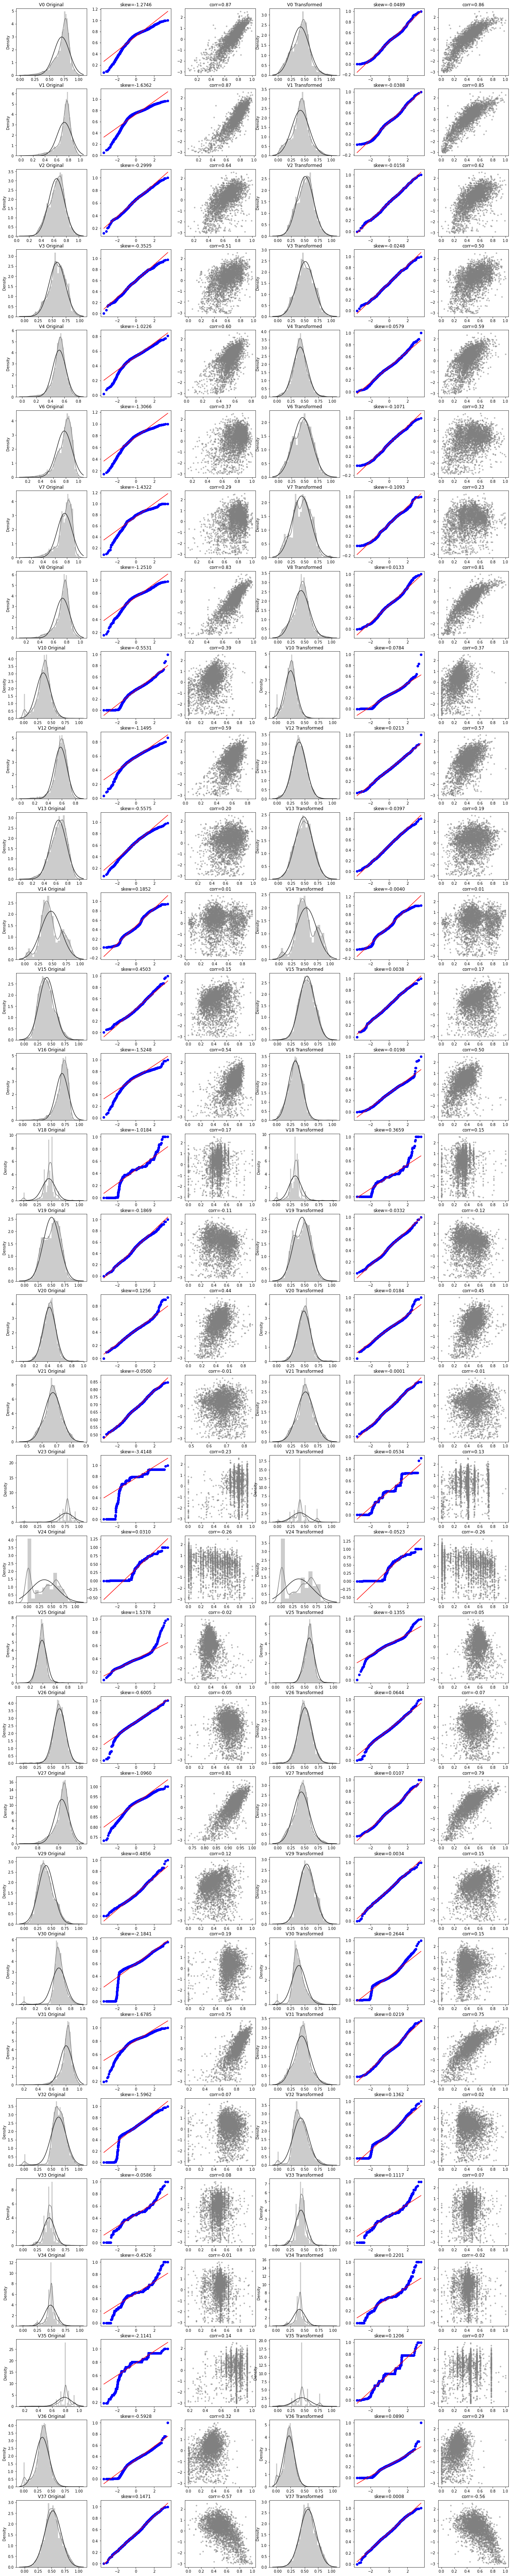

In [163]:
fcols = 6
frows = len(cols_numeric) - 1
plt.figure(figsize = (4 * fcols, 4 * frows))
i = 0

for var in cols_numeric:
    if var != 'target':
        dat = data_all[[var, 'target']].dropna()
        
        i += 1
        plt.subplot(frows, fcols, i)
        sns.distplot(dat[var], color = "gray", fit = stats.norm);
        plt.title(var + ' Original')
        plt.xlabel('')
        
        i += 1
        plt.subplot(frows, fcols, i)
        _ = stats.probplot(dat[var], plot = plt)
        plt.title('skew=' + '{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i += 1
        plt.subplot(frows, fcols, i)
        plt.plot(dat[var], dat['target'], '.', color = "gray", alpha = 0.5)
        plt.title('corr=' + '{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))
 
        i += 1
        plt.subplot(frows, fcols, i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna() + 1)
        trans_var = scale_minmax(trans_var)      
        sns.distplot(trans_var, color = "gray", fit = stats.norm);
        plt.title(var + ' Transformed')
        plt.xlabel('')
        
        i += 1
        plt.subplot(frows, fcols, i)
        _ = stats.probplot(trans_var, plot = plt)
        plt.title('skew=' + '{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i += 1
        plt.subplot(frows, fcols, i)
        plt.plot(trans_var, dat['target'], '.', color = "gray", alpha = 0.5)
        plt.title('corr=' + '{:.2f}'.format(np.corrcoef(trans_var,dat['target'])[0][1]))
plt.show()

In [164]:
# apply boxcox transform to get better normal distribution
cols_transform = data_all.columns[0:-2]
for col in cols_transform:
    # transform column
    data_all.loc[:, col], _ = stats.boxcox(data_all.loc[:, col] + 1)

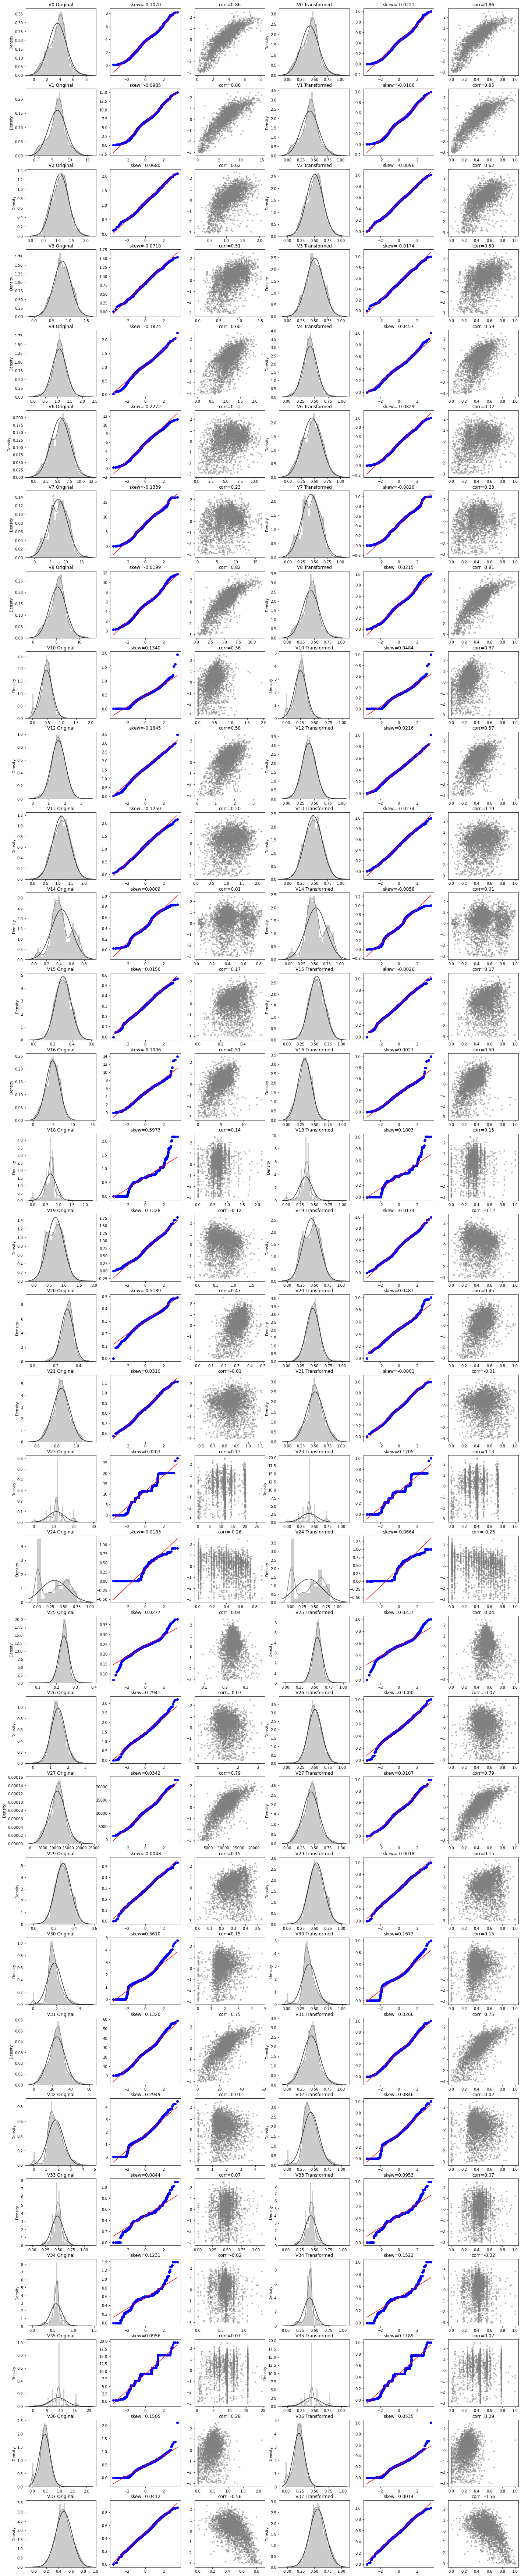

In [165]:
fcols = 6
frows = len(cols_numeric) - 1
plt.figure(figsize = (4 * fcols, 4 * frows))
i = 0

for var in cols_numeric:
    if var != 'target':
        dat = data_all[[var, 'target']].dropna()
        
        i += 1
        plt.subplot(frows, fcols, i)
        sns.distplot(dat[var], color = "gray", fit = stats.norm);
        plt.title(var + ' Original')
        plt.xlabel('')
        
        i += 1
        plt.subplot(frows, fcols, i)
        _ = stats.probplot(dat[var], plot = plt)
        plt.title('skew=' + '{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i += 1
        plt.subplot(frows, fcols, i)
        plt.plot(dat[var], dat['target'], '.', color = "gray", alpha = 0.5)
        plt.title('corr=' + '{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))
 
        i += 1
        plt.subplot(frows, fcols, i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna() + 1)
        trans_var = scale_minmax(trans_var)      
        sns.distplot(trans_var, color = "gray", fit = stats.norm);
        plt.title(var + ' Transformed')
        plt.xlabel('')
        
        i += 1
        plt.subplot(frows, fcols, i)
        _ = stats.probplot(trans_var, plot = plt)
        plt.title('skew=' + '{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i += 1
        plt.subplot(frows, fcols, i)
        plt.plot(trans_var, dat['target'], '.', color = "gray", alpha = 0.5)
        plt.title('corr=' + '{:.2f}'.format(np.corrcoef(trans_var,dat['target'])[0][1]))
plt.show()

count    2888.000000
mean        0.126353
std         0.983966
min        -3.044000
25%        -0.350250
50%         0.313000
75%         0.793250
max         2.538000
Name: target, dtype: float64


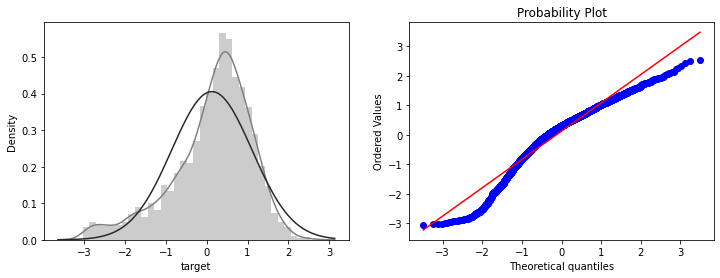

In [166]:
print(data_all.target.describe())

plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
sns.distplot(data_all.target.dropna(), color = "gray", fit = stats.norm);
plt.subplot(1, 2, 2)
_ = stats.probplot(data_all.target.dropna(), plot = plt)
plt.show()

count    2888.000000
mean        1.129957
std         0.394110
min         0.291057
25%         0.867609
50%         1.135315
75%         1.379382
max         2.798463
Name: target, dtype: float64


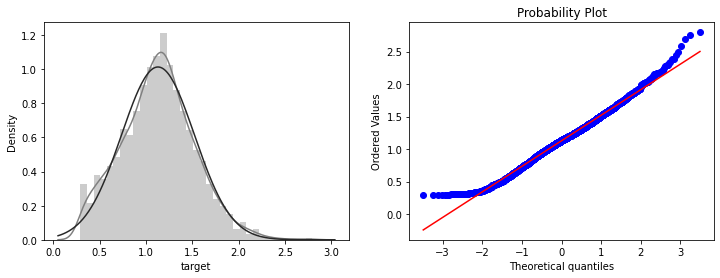

In [167]:
# Log transform target to improve normality
sp = data_train.target
data_train.target1 = np.power(1.5, sp)
print(data_train.target1.describe())

plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
sns.distplot(data_train.target1.dropna(), color = "gray", fit = stats.norm);
plt.subplot(1, 2, 2)
_ = stats.probplot(data_train.target1.dropna(), plot = plt)
plt.show()

In [168]:
# function to get training samples
def get_training_data():
    # extract training samples
    from sklearn.model_selection import train_test_split
    df_train = data_all[data_all["origin"] == "train"]
    df_train["label"] = data_train.target1
    # split target and features
    y = df_train.target
    X = df_train.drop(["origin", "target", "label"], axis = 1)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.3, random_state = 100)
    return X_train,X_valid,y_train,y_valid

# extract test data (without target)
def get_test_data():
    df_test = data_all[data_all["origin"] == "test"].reset_index(drop = True)
    return df_test.drop(["origin","target"], axis = 1)

In [169]:
from sklearn.metrics import make_scorer
# Root mean square error
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff ** 2)
    n = len(y_pred)
    return np.sqrt(sum_sq / n)

# Mean square error
def mse(y_ture, y_pred):
    return mean_squared_error(y_ture, y_pred)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better = False)
mse_scorer = make_scorer(mse, greater_is_better = False)

In [170]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma = 3):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index = y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index = y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z| > sigma
    z = (resid - mean_resid) / std_resid    
    outliers = z[abs(z) > sigma].index
    
    # print and plot the results
    print('R2 =', model.score(X, y))
    print('rmse =', rmse(y, y_pred))
    print("mse =", mean_squared_error(y, y_pred))
    print('---------------------------------------')

    print('mean of residuals:', mean_resid)
    print('std of residuals:', std_resid)
    print('---------------------------------------')

    print(len(outliers), 'outliers:')
    print(outliers.tolist())

    plt.figure(figsize = (15, 5))
    ax_131 = plt.subplot(1, 3, 1)
    plt.plot(y, y_pred, '.', color = "gray")
    plt.plot(y.loc[outliers], y_pred.loc[outliers], 'rx')
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_132 = plt.subplot(1, 3, 2)
    plt.plot(y, y - y_pred, '.', color = "gray")
    plt.plot(y.loc[outliers], y.loc[outliers] - y_pred.loc[outliers], 'rx')
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_133 = plt.subplot(1, 3, 3)
    z.plot.hist(bins = 50, ax = ax_133, color = "gray")
    z.loc[outliers].plot.hist(color = 'r', bins = 50, ax = ax_133)
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    plt.show()
    return outliers

R2 = 0.6179535683368015
rmse = 0.6142689695044993
mse = 0.37732636689611937
---------------------------------------
mean of residuals: -6.30206755987125e-16
std of residuals: 0.6144209974661153
---------------------------------------
19 outliers:
[1442, 2255, 2663, 1365, 2030, 2579, 2253, 1126, 332, 2254, 2257, 2636, 1874, 2581, 2580, 884, 1477, 2790, 1932]


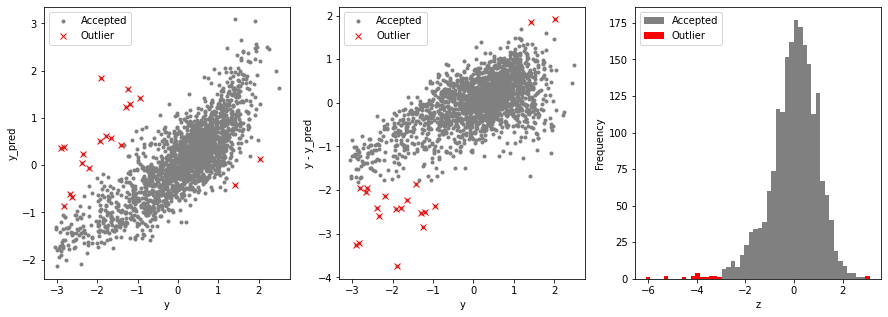

In [171]:
# Using a Lasso model to find and remove outliers
from sklearn.linear_model import Lasso
X_train, X_valid, y_train, y_valid = get_training_data()
test = get_test_data()

outliers = find_outliers(Lasso(), X_train, y_train)

X_outliers = X_train.loc[outliers]
y_outliers = y_train.loc[outliers]
X_t = X_train.drop(outliers)
y_t = y_train.drop(outliers)

R2 = 0.8794138468263232
rmse = 0.3451033885354636
mse = 0.11909634877865909
---------------------------------------
mean of residuals: 6.965674394976242e-17
std of residuals: 0.3451887995969211
---------------------------------------
23 outliers:
[2655, 2159, 1164, 2863, 1145, 2697, 2528, 2645, 691, 1085, 1874, 2647, 776, 2625, 884, 2696, 2668, 1310, 1901, 2769, 2002, 2669, 1040]


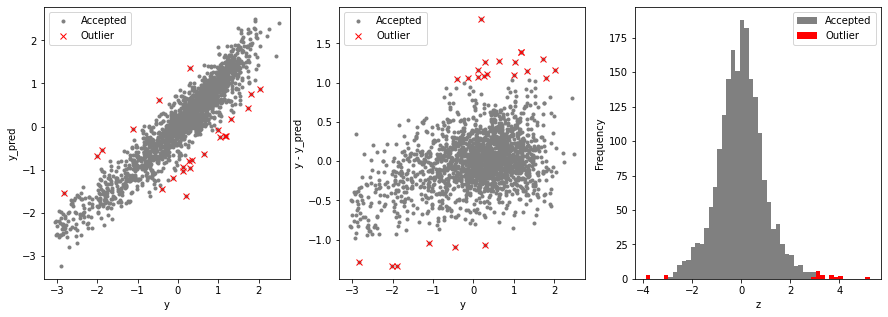

In [172]:
# Using a Ridge model to find and remove outliers
from sklearn.linear_model import Ridge
X_train, X_valid, y_train, y_valid = get_training_data()
test = get_test_data()

outliers = find_outliers(Ridge(), X_train, y_train)

X_outliers = X_train.loc[outliers]
y_outliers = y_train.loc[outliers]
X_t = X_train.drop(outliers)
y_t = y_train.drop(outliers)

In [173]:
def get_trainning_data_omitoutliers():
    y1 = y_t.copy()
    X1 = X_t.copy()
    return X1, y1

In [174]:
# Apply grid search and train model
from sklearn.preprocessing import StandardScaler
def train_model(model, param_grid = [], X = [], y = [], 
                splits = 5, repeats = 5):

    # get unmodified training data, unless data to use already specified
    if len(y) == 0:
        X, y = get_trainning_data_omitoutliers()
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits = splits, n_repeats = repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid) > 0:
        # set up grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv = rkfold,
                               scoring = "neg_mean_squared_error",
                               verbose = 1, return_train_score = True)

        # search the grid
        gsearch.fit(X, y)

        # extract best model from the grid
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx, 'mean_test_score'])
        cv_std = grid_results.loc[best_idx, 'std_test_score']

    # no grid search, just cross-val score for the given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean, 'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('score =', model.score(X,y))
    print('rmse =', rmse(y, y_pred))
    print('mse =', mse(y, y_pred))
    print('cross_val: mean =', cv_mean, ', std =', cv_std)
    
    # residual plots
    y_pred = pd.Series(y_pred, index = y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid) / std_resid    
    n_outliers = sum(abs(z) > 3)
    
    plt.figure(figsize = (17, 5))
    ax_131 = plt.subplot(1, 3, 1)
    plt.plot(y,y_pred, '.', color = "gray")
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y, y_pred)[0][1]))
    ax_132 = plt.subplot(1, 3, 2)
    plt.plot(y, y - y_pred, '.', color = "gray")
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax_133 = plt.subplot(1, 3, 3)
    z.plot.hist(bins = 50, ax = ax_133, color = "gray")
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))
    plt.show()
    return model, cv_score, grid_results

In [175]:
# places to store optimal models and scores
opt_models = dict()
score_models = pd.DataFrame(columns = ['mean','std'])

# no. k-fold splits
splits = 5
# no. k-fold iterations
repeats = 5

In [176]:
def model_predict(test_data, test_y = [], stack = False):

    i = 0
    y_predict_total = np.zeros((test_data.shape[0],))
    for model in opt_models.keys():
        if model != "LinearSVR" and model != "KNeighbors":
            y_predict = opt_models[model].predict(test_data)
            y_predict_total += y_predict
            i += 1
        if len(test_y) > 0:
            print("{}_mse:".format(model), mean_squared_error(y_predict, test_y))
    y_predict_mean = np.round(y_predict_total / i, 3)
    if len(test_y) > 0:
        print("mean_mse:", mean_squared_error(y_predict_mean, test_y))
    else:
        y_predict_mean = pd.Series(y_predict_mean)
        return y_predict_mean

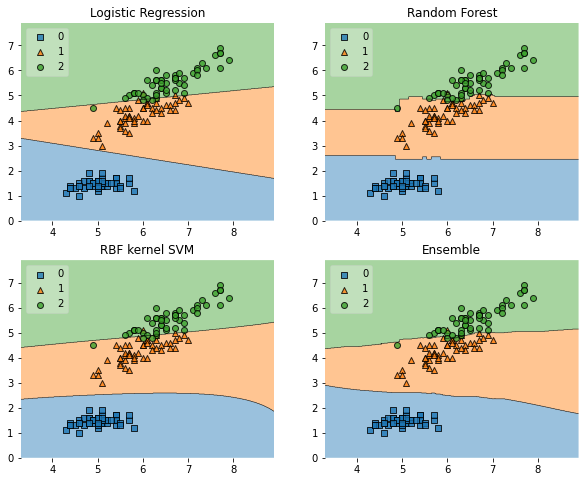

In [177]:
# stacking
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# Initializing Classifiers
clf1 = LogisticRegression(random_state = 0)
clf2 = RandomForestClassifier(random_state = 0)
clf3 = SVC(random_state = 0, probability = True)
eclf = EnsembleVoteClassifier(clfs = [clf1, clf2, clf3], weights = [2, 1, 1], voting = 'soft')

# Loading some example data
X, y = iris_data()
X = X[:,[0, 2]]

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize = (10, 8))

for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                         ['Logistic Regression', 'Random Forest', 'RBF kernel SVM', 'Ensemble'],
                         itertools.product([0, 1], repeat = 2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = X, y = y, clf = clf, legend = 2)
    plt.title(lab)
plt.show()

In [178]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy import sparse
import xgboost
import lightgbm

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def stacking_reg(clf, train_x, train_y, test_x, clf_name, kf,label_split = None):
    train = np.zeros((train_x.shape[0], 1))
    test = np.zeros((test_x.shape[0], 1))
    test_pre = np.empty((folds,test_x.shape[0], 1))
    cv_scores = []
    for i,(train_index, test_index) in enumerate(kf.split(train_x,label_split)):       
        tr_x = train_x[train_index]
        tr_y = train_y[train_index]
        te_x = train_x[test_index]
        te_y = train_y[test_index]
        if clf_name in ["rf","ada","gb","et","lr","lsvc","knn"]:
            clf.fit(tr_x, tr_y)
            pre = clf.predict(te_x).reshape(-1, 1)
            train[test_index] = pre
            test_pre[i,:] = clf.predict(test_x).reshape(-1, 1)
            cv_scores.append(mean_squared_error(te_y, pre))
        elif clf_name in ["xgb"]:
            train_matrix = clf.DMatrix(tr_x, label = tr_y, missing = -1)
            test_matrix = clf.DMatrix(te_x, label = te_y, missing = -1)
            z = clf.DMatrix(test_x, label = te_y, missing = -1)
            params = {'booster': 'gbtree',
                      'eval_metric': 'rmse',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      'nthread': 12
                      }
            num_round = 10000
            early_stopping_rounds = 100
            watchlist = [(train_matrix, 'train'),
                         (test_matrix, 'eval')
                         ]
            if test_matrix:
                model = clf.train(params, train_matrix, num_boost_round = num_round,evals = watchlist,
                                  early_stopping_rounds = early_stopping_rounds
                                  )
                pre = model.predict(test_matrix,ntree_limit = model.best_ntree_limit).reshape(-1, 1)
                train[test_index] = pre
                test_pre[i,:] = model.predict(z, ntree_limit=model.best_ntree_limit).reshape(-1, 1)
                cv_scores.append(mean_squared_error(te_y, pre))

        elif clf_name in ["lgb"]:
            train_matrix = clf.Dataset(tr_x, label = tr_y)
            test_matrix = clf.Dataset(te_x, label = te_y)
            params = {
                      'boosting_type': 'gbdt',
                      'objective': 'regression_l2',
                      'metric': 'mse',
                      'min_child_weight': 1.5,
                      'num_leaves': 2 ** 5,
                      'lambda_l2': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'learning_rate': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      'nthread': 12,
                      'silent': True,
                      }
            num_round = 10000
            early_stopping_rounds = 100
            if test_matrix:
                model = clf.train(params, train_matrix, num_round, valid_sets = test_matrix,
                                  early_stopping_rounds = early_stopping_rounds
                                  )
                pre = model.predict(te_x,num_iteration = model.best_iteration).reshape(-1, 1)
                train[test_index] = pre
                test_pre[i,:] = model.predict(test_x, num_iteration = model.best_iteration).reshape(-1, 1)
                cv_scores.append(mean_squared_error(te_y, pre))
        else:
            raise IOError("Please add new clf.")
        print("%s now score is:" % clf_name,cv_scores)
    test[:] = test_pre.mean(axis = 0)
    print("%s_score_list:" % clf_name,cv_scores)
    print("%s_score_mean:" % clf_name,np.mean(cv_scores))
    return train.reshape(-1, 1), test.reshape(-1, 1)


In [179]:
# Base learner
def rf_reg(x_train, y_train, x_valid, kf, label_split = None):
    randomforest = RandomForestRegressor(n_estimators = 600, max_depth = 20, n_jobs = -1, 
                                         random_state = 2017, max_features = "auto", verbose = 1)
    rf_train, rf_test = stacking_reg(randomforest, x_train, y_train, x_valid, "rf", kf, label_split = label_split)
    return rf_train, rf_test, "rf_reg"

def ada_reg(x_train, y_train, x_valid, kf, label_split = None):
    adaboost = AdaBoostRegressor(n_estimators = 30, random_state = 2017, learning_rate = 0.01)
    ada_train, ada_test = stacking_reg(adaboost, x_train, y_train, x_valid, "ada", kf, label_split = label_split)
    return ada_train, ada_test, "ada_reg"

def gb_reg(x_train, y_train, x_valid, kf, label_split = None):
    gbdt = GradientBoostingRegressor(learning_rate = 0.04, n_estimators = 100, subsample = 0.8, 
                                     random_state = 2017, max_depth = 5, verbose = 1)
    gbdt_train, gbdt_test = stacking_reg(gbdt, x_train, y_train, x_valid, "gb", kf, label_split = label_split)
    return gbdt_train, gbdt_test, "gb_reg"

def et_reg(x_train, y_train, x_valid, kf, label_split = None):
    extratree = ExtraTreesRegressor(n_estimators = 600, max_depth = 35, max_features = "auto", 
                                    n_jobs = -1, random_state = 2017, verbose = 1)
    et_train, et_test = stacking_reg(extratree, x_train, y_train, x_valid, "et", kf, label_split = label_split)
    return et_train, et_test, "et_reg"

def lr_reg(x_train, y_train, x_valid, kf, label_split = None):
    lr_reg = LinearRegression(n_jobs = -1)
    lr_train, lr_test = stacking_reg(lr_reg, x_train, y_train, x_valid, "lr", kf, label_split = label_split)
    return lr_train, lr_test, "lr_reg"

def xgb_reg(x_train, y_train, x_valid, kf, label_split = None):
    xgb_train, xgb_test = stacking_reg(xgboost, x_train, y_train, x_valid, "xgb", kf, label_split = label_split)
    return xgb_train, xgb_test, "xgb_reg"

def lgb_reg(x_train, y_train, x_valid, kf, label_split = None):
    lgb_train, lgb_test = stacking_reg(lightgbm, x_train, y_train, x_valid, "lgb", kf, label_split = label_split)
    return lgb_train, lgb_test, "lgb_reg"

In [180]:
def stacking_pred(x_train, y_train, x_valid, kf, clf_list, label_split = None, 
                  clf_fin = "lgb", if_concat_origin = True):
    for k, clf_list in enumerate(clf_list):
        clf_list = [clf_list]
        column_list = []
        train_data_list = []
        test_data_list = []
        for clf in clf_list:
            train_data, test_data,clf_name = clf(x_train, y_train, x_valid, kf, 
                                                 label_split = label_split)
            train_data_list.append(train_data)
            test_data_list.append(test_data)
            column_list.append("clf_%s" % (clf_name))
    train = np.concatenate(train_data_list, axis = 1)
    test = np.concatenate(test_data_list, axis = 1)
    
    if if_concat_origin:
        train = np.concatenate([x_train, train], axis = 1)
        test = np.concatenate([x_valid, test], axis = 1)
    print(x_train.shape)
    print(train.shape)
    print(clf_name)
    print(clf_name in ["lgb"])
    if clf_fin in ["rf","ada","gb","et","lr","lsvc","knn"]:
        if clf_fin in ["rf"]:
            clf = RandomForestRegressor(n_estimators = 600, max_depth = 20, n_jobs = -1, 
                                        random_state = 2017, max_features = "auto",verbose = 1)
        elif clf_fin in ["ada"]:
            clf = AdaBoostRegressor(n_estimators = 30, random_state = 2017, learning_rate = 0.01)
        elif clf_fin in ["gb"]:
            clf = GradientBoostingRegressor(learning_rate = 0.04, n_estimators = 100, 
                                            subsample = 0.8, random_state = 2017, max_depth = 5, verbose = 1)
        elif clf_fin in ["et"]:
            clf = ExtraTreesRegressor(n_estimators = 600, max_depth = 35, max_features = "auto", 
                                      n_jobs = -1, random_state = 2017,verbose = 1)
        elif clf_fin in ["lr"]:
            clf = LinearRegression(n_jobs = -1)
        clf.fit(train, y_train)
        pre = clf.predict(test).reshape(-1, 1)
        return pre
    elif clf_fin in ["xgb"]:
        clf = xgboost
        train_matrix = clf.DMatrix(train, label = y_train, missing = -1)
        test_matrix = clf.DMatrix(train, label = y_train, missing = -1)
        params = {'booster': 'gbtree',
                  'eval_metric': 'rmse',
                  'gamma': 1,
                  'min_child_weight': 1.5,
                  'max_depth': 5,
                  'lambda': 10,
                  'subsample': 0.7,
                  'colsample_bytree': 0.7,
                  'colsample_bylevel': 0.7,
                  'eta': 0.03,
                  'tree_method': 'exact',
                  'seed': 2017,
                  'nthread': 12
                  }
        num_round = 10000
        early_stopping_rounds = 100
        watchlist = [(train_matrix, 'train'),
                     (test_matrix, 'eval')
                     ]
        model = clf.train(params, train_matrix, num_boost_round = num_round,evals = watchlist,
                          early_stopping_rounds = early_stopping_rounds
                          )
        pre = model.predict(test, ntree_limit = model.best_ntree_limit).reshape(-1, 1)
        return pre
    elif clf_fin in ["lgb"]:
        print(clf_name)
        clf = lightgbm
        train_matrix = clf.Dataset(train, label = y_train)
        test_matrix = clf.Dataset(train, label = y_train)
        params = {
                  'boosting_type': 'gbdt',
                  'objective': 'regression_l2',
                  'metric': 'mse',
                  'min_child_weight': 1.5,
                  'num_leaves': 2 ** 5,
                  'lambda_l2': 10,
                  'subsample': 0.7,
                  'colsample_bytree': 0.7,
                  'colsample_bylevel': 0.7,
                  'learning_rate': 0.03,
                  'tree_method': 'exact',
                  'seed': 2017,
                  'nthread': 12,
                  'silent': True,
                  }
        num_round = 10000
        early_stopping_rounds = 100
        model = clf.train(params, train_matrix,num_round,valid_sets = test_matrix,
                          early_stopping_rounds = early_stopping_rounds
                          )
        print('pred')
        pre = model.predict(test,num_iteration = model.best_iteration).reshape(-1, 1)
        print(pre)
        return pre

In [181]:
# load dataset
with open("C:/Users/Stille/Desktop/ML projects/zhengqi_train.txt")  as fr:
    data_train = pd.read_table(fr,sep = "\t")
with open("C:/Users/Stille/Desktop/ML projects/zhengqi_test.txt") as fr_test:
    data_test = pd.read_table(fr_test, sep = "\t")

In [182]:
X, y = get_trainning_data_omitoutliers()

In [183]:
from sklearn.model_selection import StratifiedKFold, KFold

folds = 5
seed = 1
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [184]:
x_train = data_train[data_test.columns].values
x_valid = data_test[data_test.columns].values
y_train = data_train['target'].values

In [185]:
y_train.shape

(2888,)

In [186]:
clf_list = [lr_reg, lgb_reg]

pred = stacking_pred(x_train, y_train, x_valid, kf, clf_list, label_split = None, 
                     clf_fin = "lgb", if_concat_origin = True)

lr now score is: [0.11573216950871244]
lr now score is: [0.11573216950871244, 0.09417486426618936]
lr now score is: [0.11573216950871244, 0.09417486426618936, 0.10805046561851067]
lr now score is: [0.11573216950871244, 0.09417486426618936, 0.10805046561851067, 0.12420887065601556]
lr now score is: [0.11573216950871244, 0.09417486426618936, 0.10805046561851067, 0.12420887065601556, 0.11940113841914012]
lr_score_list: [0.11573216950871244, 0.09417486426618936, 0.10805046561851067, 0.12420887065601556, 0.11940113841914012]
lr_score_mean: 0.11231350169371361
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force

[281]	valid_0's l2: 0.116624
[282]	valid_0's l2: 0.116609
[283]	valid_0's l2: 0.116566
[284]	valid_0's l2: 0.116513
[285]	valid_0's l2: 0.116429
[286]	valid_0's l2: 0.116397
[287]	valid_0's l2: 0.116341
[288]	valid_0's l2: 0.116352
[289]	valid_0's l2: 0.116273
[290]	valid_0's l2: 0.116209
[291]	valid_0's l2: 0.116211
[292]	valid_0's l2: 0.116152
[293]	valid_0's l2: 0.116054
[294]	valid_0's l2: 0.116108
[295]	valid_0's l2: 0.116138
[296]	valid_0's l2: 0.116053
[297]	valid_0's l2: 0.115981
[298]	valid_0's l2: 0.115985
[299]	valid_0's l2: 0.115993
[300]	valid_0's l2: 0.116019
[301]	valid_0's l2: 0.115995
[302]	valid_0's l2: 0.115975
[303]	valid_0's l2: 0.116
[304]	valid_0's l2: 0.116
[305]	valid_0's l2: 0.116021
[306]	valid_0's l2: 0.115995
[307]	valid_0's l2: 0.11593
[308]	valid_0's l2: 0.116007
[309]	valid_0's l2: 0.115919
[310]	valid_0's l2: 0.115891
[311]	valid_0's l2: 0.115829
[312]	valid_0's l2: 0.115794
[313]	valid_0's l2: 0.115731
[314]	valid_0's l2: 0.115761
[315]	valid_0's l2: 0

[618]	valid_0's l2: 0.112163
[619]	valid_0's l2: 0.112157
[620]	valid_0's l2: 0.112163
[621]	valid_0's l2: 0.112151
[622]	valid_0's l2: 0.112158
[623]	valid_0's l2: 0.112142
[624]	valid_0's l2: 0.112115
[625]	valid_0's l2: 0.112117
[626]	valid_0's l2: 0.112134
[627]	valid_0's l2: 0.112117
[628]	valid_0's l2: 0.112089
[629]	valid_0's l2: 0.112073
[630]	valid_0's l2: 0.112064
[631]	valid_0's l2: 0.112071
[632]	valid_0's l2: 0.11207
[633]	valid_0's l2: 0.112073
[634]	valid_0's l2: 0.112074
[635]	valid_0's l2: 0.112074
[636]	valid_0's l2: 0.112055
[637]	valid_0's l2: 0.112059
[638]	valid_0's l2: 0.112049
[639]	valid_0's l2: 0.112052
[640]	valid_0's l2: 0.112038
[641]	valid_0's l2: 0.112022
[642]	valid_0's l2: 0.11204
[643]	valid_0's l2: 0.11205
[644]	valid_0's l2: 0.11205
[645]	valid_0's l2: 0.112035
[646]	valid_0's l2: 0.11203
[647]	valid_0's l2: 0.112004
[648]	valid_0's l2: 0.111996
[649]	valid_0's l2: 0.111988
[650]	valid_0's l2: 0.11197
[651]	valid_0's l2: 0.111983
[652]	valid_0's l2: 

[913]	valid_0's l2: 0.111094
[914]	valid_0's l2: 0.111084
[915]	valid_0's l2: 0.111078
[916]	valid_0's l2: 0.11108
[917]	valid_0's l2: 0.111083
[918]	valid_0's l2: 0.111081
[919]	valid_0's l2: 0.111069
[920]	valid_0's l2: 0.111072
[921]	valid_0's l2: 0.111078
[922]	valid_0's l2: 0.111076
[923]	valid_0's l2: 0.111078
[924]	valid_0's l2: 0.111083
[925]	valid_0's l2: 0.111083
[926]	valid_0's l2: 0.111074
[927]	valid_0's l2: 0.11108
[928]	valid_0's l2: 0.11108
[929]	valid_0's l2: 0.111068
[930]	valid_0's l2: 0.111061
[931]	valid_0's l2: 0.111061
[932]	valid_0's l2: 0.111047
[933]	valid_0's l2: 0.111026
[934]	valid_0's l2: 0.111028
[935]	valid_0's l2: 0.111024
[936]	valid_0's l2: 0.11103
[937]	valid_0's l2: 0.111023
[938]	valid_0's l2: 0.111017
[939]	valid_0's l2: 0.111
[940]	valid_0's l2: 0.110999
[941]	valid_0's l2: 0.111001
[942]	valid_0's l2: 0.111002
[943]	valid_0's l2: 0.110994
[944]	valid_0's l2: 0.110997
[945]	valid_0's l2: 0.110986
[946]	valid_0's l2: 0.110992
[947]	valid_0's l2: 0

[1204]	valid_0's l2: 0.110504
[1205]	valid_0's l2: 0.110511
[1206]	valid_0's l2: 0.110505
[1207]	valid_0's l2: 0.110496
[1208]	valid_0's l2: 0.110488
[1209]	valid_0's l2: 0.11049
[1210]	valid_0's l2: 0.110478
[1211]	valid_0's l2: 0.110472
[1212]	valid_0's l2: 0.110475
[1213]	valid_0's l2: 0.110472
[1214]	valid_0's l2: 0.110465
[1215]	valid_0's l2: 0.110464
[1216]	valid_0's l2: 0.110469
[1217]	valid_0's l2: 0.110474
[1218]	valid_0's l2: 0.110481
[1219]	valid_0's l2: 0.110487
[1220]	valid_0's l2: 0.110483
[1221]	valid_0's l2: 0.110486
[1222]	valid_0's l2: 0.110482
[1223]	valid_0's l2: 0.110489
[1224]	valid_0's l2: 0.110487
[1225]	valid_0's l2: 0.110479
[1226]	valid_0's l2: 0.110477
[1227]	valid_0's l2: 0.110476
[1228]	valid_0's l2: 0.110471
[1229]	valid_0's l2: 0.110461
[1230]	valid_0's l2: 0.110462
[1231]	valid_0's l2: 0.110458
[1232]	valid_0's l2: 0.110458
[1233]	valid_0's l2: 0.110462
[1234]	valid_0's l2: 0.110463
[1235]	valid_0's l2: 0.11047
[1236]	valid_0's l2: 0.110471
[1237]	valid

[1517]	valid_0's l2: 0.110265
[1518]	valid_0's l2: 0.110266
[1519]	valid_0's l2: 0.110265
[1520]	valid_0's l2: 0.110266
[1521]	valid_0's l2: 0.110269
[1522]	valid_0's l2: 0.110264
[1523]	valid_0's l2: 0.110265
[1524]	valid_0's l2: 0.110269
[1525]	valid_0's l2: 0.110264
[1526]	valid_0's l2: 0.110261
[1527]	valid_0's l2: 0.110262
[1528]	valid_0's l2: 0.110262
[1529]	valid_0's l2: 0.110259
[1530]	valid_0's l2: 0.110265
[1531]	valid_0's l2: 0.110266
[1532]	valid_0's l2: 0.110264
[1533]	valid_0's l2: 0.110266
[1534]	valid_0's l2: 0.110271
[1535]	valid_0's l2: 0.110277
[1536]	valid_0's l2: 0.110274
[1537]	valid_0's l2: 0.11027
[1538]	valid_0's l2: 0.11027
[1539]	valid_0's l2: 0.110271
[1540]	valid_0's l2: 0.110276
[1541]	valid_0's l2: 0.110279
[1542]	valid_0's l2: 0.110277
[1543]	valid_0's l2: 0.110279
[1544]	valid_0's l2: 0.11028
[1545]	valid_0's l2: 0.110278
[1546]	valid_0's l2: 0.110274
[1547]	valid_0's l2: 0.110269
[1548]	valid_0's l2: 0.11027
[1549]	valid_0's l2: 0.110269
[1550]	valid_0

[237]	valid_0's l2: 0.101608
[238]	valid_0's l2: 0.101607
[239]	valid_0's l2: 0.101464
[240]	valid_0's l2: 0.101384
[241]	valid_0's l2: 0.101364
[242]	valid_0's l2: 0.101346
[243]	valid_0's l2: 0.101302
[244]	valid_0's l2: 0.101225
[245]	valid_0's l2: 0.101195
[246]	valid_0's l2: 0.101125
[247]	valid_0's l2: 0.101072
[248]	valid_0's l2: 0.101005
[249]	valid_0's l2: 0.100976
[250]	valid_0's l2: 0.100874
[251]	valid_0's l2: 0.100874
[252]	valid_0's l2: 0.100843
[253]	valid_0's l2: 0.100802
[254]	valid_0's l2: 0.100783
[255]	valid_0's l2: 0.100779
[256]	valid_0's l2: 0.100681
[257]	valid_0's l2: 0.10069
[258]	valid_0's l2: 0.100656
[259]	valid_0's l2: 0.100587
[260]	valid_0's l2: 0.100539
[261]	valid_0's l2: 0.100492
[262]	valid_0's l2: 0.10048
[263]	valid_0's l2: 0.100485
[264]	valid_0's l2: 0.100487
[265]	valid_0's l2: 0.100397
[266]	valid_0's l2: 0.100363
[267]	valid_0's l2: 0.100408
[268]	valid_0's l2: 0.100387
[269]	valid_0's l2: 0.100363
[270]	valid_0's l2: 0.100378
[271]	valid_0's 

[561]	valid_0's l2: 0.0969148
[562]	valid_0's l2: 0.0968714
[563]	valid_0's l2: 0.0968825
[564]	valid_0's l2: 0.0969013
[565]	valid_0's l2: 0.0969035
[566]	valid_0's l2: 0.0968938
[567]	valid_0's l2: 0.0969015
[568]	valid_0's l2: 0.0968944
[569]	valid_0's l2: 0.0968954
[570]	valid_0's l2: 0.0968868
[571]	valid_0's l2: 0.0968889
[572]	valid_0's l2: 0.0968809
[573]	valid_0's l2: 0.0968818
[574]	valid_0's l2: 0.0968755
[575]	valid_0's l2: 0.096853
[576]	valid_0's l2: 0.0968338
[577]	valid_0's l2: 0.0968239
[578]	valid_0's l2: 0.0968224
[579]	valid_0's l2: 0.096826
[580]	valid_0's l2: 0.0968097
[581]	valid_0's l2: 0.0968191
[582]	valid_0's l2: 0.0968095
[583]	valid_0's l2: 0.0968197
[584]	valid_0's l2: 0.0967978
[585]	valid_0's l2: 0.0967779
[586]	valid_0's l2: 0.0967638
[587]	valid_0's l2: 0.0967489
[588]	valid_0's l2: 0.0967524
[589]	valid_0's l2: 0.0967598
[590]	valid_0's l2: 0.0967588
[591]	valid_0's l2: 0.0967671
[592]	valid_0's l2: 0.0967692
[593]	valid_0's l2: 0.0967765
[594]	valid_

[868]	valid_0's l2: 0.0960711
[869]	valid_0's l2: 0.0960537
[870]	valid_0's l2: 0.0960606
[871]	valid_0's l2: 0.0960627
[872]	valid_0's l2: 0.0960685
[873]	valid_0's l2: 0.0960643
[874]	valid_0's l2: 0.0960743
[875]	valid_0's l2: 0.096092
[876]	valid_0's l2: 0.0960747
[877]	valid_0's l2: 0.0960591
[878]	valid_0's l2: 0.0960676
[879]	valid_0's l2: 0.096065
[880]	valid_0's l2: 0.0960638
[881]	valid_0's l2: 0.096053
[882]	valid_0's l2: 0.0960517
[883]	valid_0's l2: 0.0960456
[884]	valid_0's l2: 0.0960502
[885]	valid_0's l2: 0.0960568
[886]	valid_0's l2: 0.0960712
[887]	valid_0's l2: 0.0960658
[888]	valid_0's l2: 0.0960662
[889]	valid_0's l2: 0.0960635
[890]	valid_0's l2: 0.0960666
[891]	valid_0's l2: 0.0960485
[892]	valid_0's l2: 0.0960393
[893]	valid_0's l2: 0.0960112
[894]	valid_0's l2: 0.0960139
[895]	valid_0's l2: 0.0960157
[896]	valid_0's l2: 0.0960146
[897]	valid_0's l2: 0.0960183
[898]	valid_0's l2: 0.0960084
[899]	valid_0's l2: 0.0960221
[900]	valid_0's l2: 0.0960146
[901]	valid_0

lgb now score is: [0.1102416734274187, 0.09584823314325594]
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8847
[LightGBM] [Info] Number of data points in the train set: 2310, number of used features: 38
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Start training from score 0.137391
[1]	valid_0's l2: 0.925026
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.882263
[3]	valid

[285]	valid_0's l2: 0.103152
[286]	valid_0's l2: 0.103149
[287]	valid_0's l2: 0.103137
[288]	valid_0's l2: 0.103113
[289]	valid_0's l2: 0.10317
[290]	valid_0's l2: 0.103133
[291]	valid_0's l2: 0.103127
[292]	valid_0's l2: 0.103096
[293]	valid_0's l2: 0.103075
[294]	valid_0's l2: 0.103036
[295]	valid_0's l2: 0.103032
[296]	valid_0's l2: 0.102988
[297]	valid_0's l2: 0.102985
[298]	valid_0's l2: 0.102999
[299]	valid_0's l2: 0.102952
[300]	valid_0's l2: 0.102976
[301]	valid_0's l2: 0.102994
[302]	valid_0's l2: 0.10304
[303]	valid_0's l2: 0.103067
[304]	valid_0's l2: 0.103027
[305]	valid_0's l2: 0.103023
[306]	valid_0's l2: 0.103009
[307]	valid_0's l2: 0.103008
[308]	valid_0's l2: 0.103059
[309]	valid_0's l2: 0.103004
[310]	valid_0's l2: 0.102916
[311]	valid_0's l2: 0.102901
[312]	valid_0's l2: 0.10285
[313]	valid_0's l2: 0.102885
[314]	valid_0's l2: 0.102853
[315]	valid_0's l2: 0.102858
[316]	valid_0's l2: 0.102871
[317]	valid_0's l2: 0.102798
[318]	valid_0's l2: 0.102791
[319]	valid_0's l

[648]	valid_0's l2: 0.100939
[649]	valid_0's l2: 0.100974
[650]	valid_0's l2: 0.100955
[651]	valid_0's l2: 0.100941
[652]	valid_0's l2: 0.100936
[653]	valid_0's l2: 0.10094
[654]	valid_0's l2: 0.100916
[655]	valid_0's l2: 0.100925
[656]	valid_0's l2: 0.100935
[657]	valid_0's l2: 0.100927
[658]	valid_0's l2: 0.100925
[659]	valid_0's l2: 0.100903
[660]	valid_0's l2: 0.100925
[661]	valid_0's l2: 0.100913
[662]	valid_0's l2: 0.100903
[663]	valid_0's l2: 0.100925
[664]	valid_0's l2: 0.100898
[665]	valid_0's l2: 0.100883
[666]	valid_0's l2: 0.100876
[667]	valid_0's l2: 0.100877
[668]	valid_0's l2: 0.100878
[669]	valid_0's l2: 0.100883
Early stopping, best iteration is:
[569]	valid_0's l2: 0.100667
lgb now score is: [0.1102416734274187, 0.09584823314325594, 0.10066714133459925]
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[Li

[296]	valid_0's l2: 0.116569
[297]	valid_0's l2: 0.11651
[298]	valid_0's l2: 0.116459
[299]	valid_0's l2: 0.116448
[300]	valid_0's l2: 0.116377
[301]	valid_0's l2: 0.116332
[302]	valid_0's l2: 0.116302
[303]	valid_0's l2: 0.116206
[304]	valid_0's l2: 0.116181
[305]	valid_0's l2: 0.11621
[306]	valid_0's l2: 0.116195
[307]	valid_0's l2: 0.116138
[308]	valid_0's l2: 0.116128
[309]	valid_0's l2: 0.116061
[310]	valid_0's l2: 0.116021
[311]	valid_0's l2: 0.116014
[312]	valid_0's l2: 0.11599
[313]	valid_0's l2: 0.115987
[314]	valid_0's l2: 0.115936
[315]	valid_0's l2: 0.115952
[316]	valid_0's l2: 0.115952
[317]	valid_0's l2: 0.11591
[318]	valid_0's l2: 0.115905
[319]	valid_0's l2: 0.115813
[320]	valid_0's l2: 0.115804
[321]	valid_0's l2: 0.115803
[322]	valid_0's l2: 0.115789
[323]	valid_0's l2: 0.115777
[324]	valid_0's l2: 0.115737
[325]	valid_0's l2: 0.11575
[326]	valid_0's l2: 0.115736
[327]	valid_0's l2: 0.115735
[328]	valid_0's l2: 0.115712
[329]	valid_0's l2: 0.115731
[330]	valid_0's l2:

[674]	valid_0's l2: 0.113565
[675]	valid_0's l2: 0.11356
[676]	valid_0's l2: 0.113548
[677]	valid_0's l2: 0.11356
[678]	valid_0's l2: 0.113538
[679]	valid_0's l2: 0.113556
[680]	valid_0's l2: 0.113564
[681]	valid_0's l2: 0.113546
[682]	valid_0's l2: 0.113532
[683]	valid_0's l2: 0.11351
[684]	valid_0's l2: 0.113502
[685]	valid_0's l2: 0.113509
[686]	valid_0's l2: 0.113519
[687]	valid_0's l2: 0.113495
[688]	valid_0's l2: 0.113474
[689]	valid_0's l2: 0.113473
[690]	valid_0's l2: 0.113479
[691]	valid_0's l2: 0.11347
[692]	valid_0's l2: 0.113472
[693]	valid_0's l2: 0.113444
[694]	valid_0's l2: 0.113422
[695]	valid_0's l2: 0.113424
[696]	valid_0's l2: 0.113383
[697]	valid_0's l2: 0.113403
[698]	valid_0's l2: 0.113384
[699]	valid_0's l2: 0.113386
[700]	valid_0's l2: 0.113389
[701]	valid_0's l2: 0.11339
[702]	valid_0's l2: 0.113399
[703]	valid_0's l2: 0.113388
[704]	valid_0's l2: 0.113405
[705]	valid_0's l2: 0.113408
[706]	valid_0's l2: 0.11338
[707]	valid_0's l2: 0.113373
[708]	valid_0's l2: 

[960]	valid_0's l2: 0.11307
[961]	valid_0's l2: 0.113069
[962]	valid_0's l2: 0.113069
[963]	valid_0's l2: 0.113057
[964]	valid_0's l2: 0.113051
[965]	valid_0's l2: 0.113061
[966]	valid_0's l2: 0.113052
[967]	valid_0's l2: 0.113045
[968]	valid_0's l2: 0.113062
[969]	valid_0's l2: 0.113049
[970]	valid_0's l2: 0.113068
[971]	valid_0's l2: 0.113059
[972]	valid_0's l2: 0.113045
[973]	valid_0's l2: 0.113042
[974]	valid_0's l2: 0.113049
[975]	valid_0's l2: 0.113041
[976]	valid_0's l2: 0.113039
[977]	valid_0's l2: 0.113046
[978]	valid_0's l2: 0.113044
[979]	valid_0's l2: 0.113051
[980]	valid_0's l2: 0.113053
[981]	valid_0's l2: 0.113044
[982]	valid_0's l2: 0.113051
[983]	valid_0's l2: 0.113055
[984]	valid_0's l2: 0.113058
Early stopping, best iteration is:
[884]	valid_0's l2: 0.113026
lgb now score is: [0.1102416734274187, 0.09584823314325594, 0.10066714133459925, 0.11302566196029616]
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method


[248]	valid_0's l2: 0.108667
[249]	valid_0's l2: 0.108628
[250]	valid_0's l2: 0.108674
[251]	valid_0's l2: 0.10863
[252]	valid_0's l2: 0.108624
[253]	valid_0's l2: 0.108566
[254]	valid_0's l2: 0.108488
[255]	valid_0's l2: 0.108443
[256]	valid_0's l2: 0.108413
[257]	valid_0's l2: 0.108392
[258]	valid_0's l2: 0.108343
[259]	valid_0's l2: 0.10836
[260]	valid_0's l2: 0.108346
[261]	valid_0's l2: 0.108361
[262]	valid_0's l2: 0.108367
[263]	valid_0's l2: 0.108289
[264]	valid_0's l2: 0.108259
[265]	valid_0's l2: 0.108212
[266]	valid_0's l2: 0.108262
[267]	valid_0's l2: 0.10822
[268]	valid_0's l2: 0.108101
[269]	valid_0's l2: 0.108019
[270]	valid_0's l2: 0.108008
[271]	valid_0's l2: 0.107976
[272]	valid_0's l2: 0.108033
[273]	valid_0's l2: 0.107989
[274]	valid_0's l2: 0.107926
[275]	valid_0's l2: 0.107947
[276]	valid_0's l2: 0.107964
[277]	valid_0's l2: 0.107889
[278]	valid_0's l2: 0.107856
[279]	valid_0's l2: 0.107835
[280]	valid_0's l2: 0.107718
[281]	valid_0's l2: 0.107649
[282]	valid_0's l

[607]	valid_0's l2: 0.104752
[608]	valid_0's l2: 0.104722
[609]	valid_0's l2: 0.104707
[610]	valid_0's l2: 0.104721
[611]	valid_0's l2: 0.104729
[612]	valid_0's l2: 0.104742
[613]	valid_0's l2: 0.104748
[614]	valid_0's l2: 0.104739
[615]	valid_0's l2: 0.104741
[616]	valid_0's l2: 0.104725
[617]	valid_0's l2: 0.104702
[618]	valid_0's l2: 0.104691
[619]	valid_0's l2: 0.104687
[620]	valid_0's l2: 0.104684
[621]	valid_0's l2: 0.104689
[622]	valid_0's l2: 0.104669
[623]	valid_0's l2: 0.104663
[624]	valid_0's l2: 0.104669
[625]	valid_0's l2: 0.104676
[626]	valid_0's l2: 0.104701
[627]	valid_0's l2: 0.104691
[628]	valid_0's l2: 0.104687
[629]	valid_0's l2: 0.104664
[630]	valid_0's l2: 0.104655
[631]	valid_0's l2: 0.10464
[632]	valid_0's l2: 0.104644
[633]	valid_0's l2: 0.104647
[634]	valid_0's l2: 0.104651
[635]	valid_0's l2: 0.10467
[636]	valid_0's l2: 0.104655
[637]	valid_0's l2: 0.104662
[638]	valid_0's l2: 0.104655
[639]	valid_0's l2: 0.104644
[640]	valid_0's l2: 0.10463
[641]	valid_0's l

[962]	valid_0's l2: 0.104246
[963]	valid_0's l2: 0.104245
[964]	valid_0's l2: 0.104253
[965]	valid_0's l2: 0.104256
[966]	valid_0's l2: 0.104252
[967]	valid_0's l2: 0.104278
[968]	valid_0's l2: 0.10427
[969]	valid_0's l2: 0.10426
[970]	valid_0's l2: 0.104264
[971]	valid_0's l2: 0.104261
[972]	valid_0's l2: 0.104257
[973]	valid_0's l2: 0.104258
[974]	valid_0's l2: 0.104245
[975]	valid_0's l2: 0.104239
[976]	valid_0's l2: 0.104222
[977]	valid_0's l2: 0.104226
[978]	valid_0's l2: 0.104224
[979]	valid_0's l2: 0.104231
[980]	valid_0's l2: 0.104222
[981]	valid_0's l2: 0.104224
[982]	valid_0's l2: 0.104216
[983]	valid_0's l2: 0.1042
[984]	valid_0's l2: 0.104202
[985]	valid_0's l2: 0.104208
[986]	valid_0's l2: 0.1042
[987]	valid_0's l2: 0.104191
[988]	valid_0's l2: 0.104193
[989]	valid_0's l2: 0.104189
[990]	valid_0's l2: 0.104192
[991]	valid_0's l2: 0.104189
[992]	valid_0's l2: 0.104189
[993]	valid_0's l2: 0.104195
[994]	valid_0's l2: 0.10419
[995]	valid_0's l2: 0.104194
[996]	valid_0's l2: 0

[1289]	valid_0's l2: 0.103911
[1290]	valid_0's l2: 0.103917
[1291]	valid_0's l2: 0.103919
[1292]	valid_0's l2: 0.103926
[1293]	valid_0's l2: 0.103928
[1294]	valid_0's l2: 0.103923
[1295]	valid_0's l2: 0.103923
[1296]	valid_0's l2: 0.103922
[1297]	valid_0's l2: 0.103919
[1298]	valid_0's l2: 0.103922
[1299]	valid_0's l2: 0.103922
[1300]	valid_0's l2: 0.103911
[1301]	valid_0's l2: 0.103904
[1302]	valid_0's l2: 0.103907
[1303]	valid_0's l2: 0.103898
[1304]	valid_0's l2: 0.103903
[1305]	valid_0's l2: 0.103906
[1306]	valid_0's l2: 0.103908
[1307]	valid_0's l2: 0.103907
[1308]	valid_0's l2: 0.103902
[1309]	valid_0's l2: 0.103911
[1310]	valid_0's l2: 0.10392
[1311]	valid_0's l2: 0.103916
[1312]	valid_0's l2: 0.103906
[1313]	valid_0's l2: 0.10391
[1314]	valid_0's l2: 0.103903
[1315]	valid_0's l2: 0.103899
[1316]	valid_0's l2: 0.103893
[1317]	valid_0's l2: 0.103891
[1318]	valid_0's l2: 0.103887
[1319]	valid_0's l2: 0.103885
[1320]	valid_0's l2: 0.103884
[1321]	valid_0's l2: 0.103885
[1322]	valid

[1598]	valid_0's l2: 0.103788
[1599]	valid_0's l2: 0.103787
[1600]	valid_0's l2: 0.103781
[1601]	valid_0's l2: 0.103785
[1602]	valid_0's l2: 0.103785
[1603]	valid_0's l2: 0.103779
[1604]	valid_0's l2: 0.103781
[1605]	valid_0's l2: 0.103781
[1606]	valid_0's l2: 0.103783
[1607]	valid_0's l2: 0.103781
[1608]	valid_0's l2: 0.103782
[1609]	valid_0's l2: 0.103779
[1610]	valid_0's l2: 0.103779
[1611]	valid_0's l2: 0.10378
[1612]	valid_0's l2: 0.103781
[1613]	valid_0's l2: 0.103778
[1614]	valid_0's l2: 0.103776
[1615]	valid_0's l2: 0.103772
[1616]	valid_0's l2: 0.103768
[1617]	valid_0's l2: 0.10376
[1618]	valid_0's l2: 0.103761
[1619]	valid_0's l2: 0.103763
[1620]	valid_0's l2: 0.103759
[1621]	valid_0's l2: 0.103759
[1622]	valid_0's l2: 0.103755
[1623]	valid_0's l2: 0.103755
[1624]	valid_0's l2: 0.103753
[1625]	valid_0's l2: 0.103751
[1626]	valid_0's l2: 0.10375
[1627]	valid_0's l2: 0.103747
[1628]	valid_0's l2: 0.103745
[1629]	valid_0's l2: 0.103744
[1630]	valid_0's l2: 0.103744
[1631]	valid_

[1894]	valid_0's l2: 0.103608
[1895]	valid_0's l2: 0.103608
[1896]	valid_0's l2: 0.103606
[1897]	valid_0's l2: 0.103605
[1898]	valid_0's l2: 0.103604
[1899]	valid_0's l2: 0.103606
[1900]	valid_0's l2: 0.103604
[1901]	valid_0's l2: 0.103605
[1902]	valid_0's l2: 0.103605
[1903]	valid_0's l2: 0.103599
[1904]	valid_0's l2: 0.103599
[1905]	valid_0's l2: 0.103595
[1906]	valid_0's l2: 0.103593
[1907]	valid_0's l2: 0.103594
[1908]	valid_0's l2: 0.103592
[1909]	valid_0's l2: 0.103594
[1910]	valid_0's l2: 0.103595
[1911]	valid_0's l2: 0.103598
[1912]	valid_0's l2: 0.103596
[1913]	valid_0's l2: 0.103596
[1914]	valid_0's l2: 0.103596
[1915]	valid_0's l2: 0.103594
[1916]	valid_0's l2: 0.103596
[1917]	valid_0's l2: 0.103593
[1918]	valid_0's l2: 0.103592
[1919]	valid_0's l2: 0.103589
[1920]	valid_0's l2: 0.103589
[1921]	valid_0's l2: 0.103586
[1922]	valid_0's l2: 0.103588
[1923]	valid_0's l2: 0.103586
[1924]	valid_0's l2: 0.103587
[1925]	valid_0's l2: 0.10359
[1926]	valid_0's l2: 0.10359
[1927]	valid

[2202]	valid_0's l2: 0.103506
[2203]	valid_0's l2: 0.103504
[2204]	valid_0's l2: 0.103504
[2205]	valid_0's l2: 0.103501
[2206]	valid_0's l2: 0.1035
[2207]	valid_0's l2: 0.1035
[2208]	valid_0's l2: 0.1035
[2209]	valid_0's l2: 0.1035
[2210]	valid_0's l2: 0.103501
[2211]	valid_0's l2: 0.103503
[2212]	valid_0's l2: 0.103502
[2213]	valid_0's l2: 0.103501
[2214]	valid_0's l2: 0.103501
[2215]	valid_0's l2: 0.103499
[2216]	valid_0's l2: 0.103497
[2217]	valid_0's l2: 0.103499
[2218]	valid_0's l2: 0.103496
[2219]	valid_0's l2: 0.103496
[2220]	valid_0's l2: 0.103501
[2221]	valid_0's l2: 0.1035
[2222]	valid_0's l2: 0.1035
[2223]	valid_0's l2: 0.103499
[2224]	valid_0's l2: 0.103498
[2225]	valid_0's l2: 0.1035
[2226]	valid_0's l2: 0.1035
[2227]	valid_0's l2: 0.103502
[2228]	valid_0's l2: 0.1035
[2229]	valid_0's l2: 0.1035
[2230]	valid_0's l2: 0.103496
[2231]	valid_0's l2: 0.103497
[2232]	valid_0's l2: 0.103497
[2233]	valid_0's l2: 0.103496
[2234]	valid_0's l2: 0.103497
[2235]	valid_0's l2: 0.103497


[2487]	valid_0's l2: 0.10347
[2488]	valid_0's l2: 0.103469
[2489]	valid_0's l2: 0.103468
[2490]	valid_0's l2: 0.103469
[2491]	valid_0's l2: 0.103468
[2492]	valid_0's l2: 0.103467
[2493]	valid_0's l2: 0.103467
[2494]	valid_0's l2: 0.103467
[2495]	valid_0's l2: 0.103469
[2496]	valid_0's l2: 0.103467
[2497]	valid_0's l2: 0.103467
[2498]	valid_0's l2: 0.103464
[2499]	valid_0's l2: 0.103464
[2500]	valid_0's l2: 0.103464
[2501]	valid_0's l2: 0.103465
[2502]	valid_0's l2: 0.103464
[2503]	valid_0's l2: 0.103465
[2504]	valid_0's l2: 0.103464
[2505]	valid_0's l2: 0.103464
[2506]	valid_0's l2: 0.103464
[2507]	valid_0's l2: 0.103463
[2508]	valid_0's l2: 0.103462
[2509]	valid_0's l2: 0.103464
[2510]	valid_0's l2: 0.103464
[2511]	valid_0's l2: 0.103465
[2512]	valid_0's l2: 0.103466
[2513]	valid_0's l2: 0.103467
[2514]	valid_0's l2: 0.103466
[2515]	valid_0's l2: 0.103465
[2516]	valid_0's l2: 0.103464
[2517]	valid_0's l2: 0.103462
[2518]	valid_0's l2: 0.103463
[2519]	valid_0's l2: 0.103464
[2520]	vali

[2861]	valid_0's l2: 0.103413
[2862]	valid_0's l2: 0.103411
[2863]	valid_0's l2: 0.103411
[2864]	valid_0's l2: 0.103411
[2865]	valid_0's l2: 0.103412
[2866]	valid_0's l2: 0.103412
[2867]	valid_0's l2: 0.103412
[2868]	valid_0's l2: 0.103411
[2869]	valid_0's l2: 0.10341
[2870]	valid_0's l2: 0.103409
[2871]	valid_0's l2: 0.103409
[2872]	valid_0's l2: 0.103408
[2873]	valid_0's l2: 0.103407
[2874]	valid_0's l2: 0.103407
[2875]	valid_0's l2: 0.103409
[2876]	valid_0's l2: 0.103409
[2877]	valid_0's l2: 0.103409
[2878]	valid_0's l2: 0.10341
[2879]	valid_0's l2: 0.10341
[2880]	valid_0's l2: 0.103412
[2881]	valid_0's l2: 0.103411
[2882]	valid_0's l2: 0.103411
[2883]	valid_0's l2: 0.103412
[2884]	valid_0's l2: 0.103412
[2885]	valid_0's l2: 0.103412
[2886]	valid_0's l2: 0.103413
[2887]	valid_0's l2: 0.103413
[2888]	valid_0's l2: 0.103412
[2889]	valid_0's l2: 0.103411
[2890]	valid_0's l2: 0.103411
[2891]	valid_0's l2: 0.103411
[2892]	valid_0's l2: 0.103411
[2893]	valid_0's l2: 0.10341
[2894]	valid_0

[189]	valid_0's l2: 0.0498028
[190]	valid_0's l2: 0.0495828
[191]	valid_0's l2: 0.0493745
[192]	valid_0's l2: 0.04918
[193]	valid_0's l2: 0.0489857
[194]	valid_0's l2: 0.0488133
[195]	valid_0's l2: 0.048617
[196]	valid_0's l2: 0.0484293
[197]	valid_0's l2: 0.0482294
[198]	valid_0's l2: 0.048034
[199]	valid_0's l2: 0.0478434
[200]	valid_0's l2: 0.0476533
[201]	valid_0's l2: 0.0474411
[202]	valid_0's l2: 0.0472419
[203]	valid_0's l2: 0.0470374
[204]	valid_0's l2: 0.0468375
[205]	valid_0's l2: 0.0466474
[206]	valid_0's l2: 0.0464805
[207]	valid_0's l2: 0.0462728
[208]	valid_0's l2: 0.0460945
[209]	valid_0's l2: 0.0458889
[210]	valid_0's l2: 0.0456952
[211]	valid_0's l2: 0.0454926
[212]	valid_0's l2: 0.0453206
[213]	valid_0's l2: 0.0451639
[214]	valid_0's l2: 0.0450138
[215]	valid_0's l2: 0.0448387
[216]	valid_0's l2: 0.0446657
[217]	valid_0's l2: 0.0444884
[218]	valid_0's l2: 0.0443069
[219]	valid_0's l2: 0.0441438
[220]	valid_0's l2: 0.0439557
[221]	valid_0's l2: 0.0437948
[222]	valid_0'

[468]	valid_0's l2: 0.0189528
[469]	valid_0's l2: 0.0188912
[470]	valid_0's l2: 0.0188343
[471]	valid_0's l2: 0.0187598
[472]	valid_0's l2: 0.0186938
[473]	valid_0's l2: 0.018636
[474]	valid_0's l2: 0.0185768
[475]	valid_0's l2: 0.0185185
[476]	valid_0's l2: 0.0184606
[477]	valid_0's l2: 0.0184015
[478]	valid_0's l2: 0.0183452
[479]	valid_0's l2: 0.0182913
[480]	valid_0's l2: 0.0182343
[481]	valid_0's l2: 0.0181807
[482]	valid_0's l2: 0.0181273
[483]	valid_0's l2: 0.0180694
[484]	valid_0's l2: 0.0180152
[485]	valid_0's l2: 0.017964
[486]	valid_0's l2: 0.0179074
[487]	valid_0's l2: 0.0178594
[488]	valid_0's l2: 0.0177938
[489]	valid_0's l2: 0.0177438
[490]	valid_0's l2: 0.0176901
[491]	valid_0's l2: 0.0176384
[492]	valid_0's l2: 0.017582
[493]	valid_0's l2: 0.0175273
[494]	valid_0's l2: 0.0174786
[495]	valid_0's l2: 0.0174142
[496]	valid_0's l2: 0.0173606
[497]	valid_0's l2: 0.0173072
[498]	valid_0's l2: 0.0172612
[499]	valid_0's l2: 0.0172142
[500]	valid_0's l2: 0.0171615
[501]	valid_0

[832]	valid_0's l2: 0.00641003
[833]	valid_0's l2: 0.00639164
[834]	valid_0's l2: 0.00637444
[835]	valid_0's l2: 0.00635384
[836]	valid_0's l2: 0.00633851
[837]	valid_0's l2: 0.00632105
[838]	valid_0's l2: 0.00630549
[839]	valid_0's l2: 0.00628959
[840]	valid_0's l2: 0.00627078
[841]	valid_0's l2: 0.0062532
[842]	valid_0's l2: 0.00623687
[843]	valid_0's l2: 0.00621839
[844]	valid_0's l2: 0.00620021
[845]	valid_0's l2: 0.00618166
[846]	valid_0's l2: 0.00616363
[847]	valid_0's l2: 0.00614574
[848]	valid_0's l2: 0.00612742
[849]	valid_0's l2: 0.00611276
[850]	valid_0's l2: 0.00609433
[851]	valid_0's l2: 0.00607775
[852]	valid_0's l2: 0.00605881
[853]	valid_0's l2: 0.00604142
[854]	valid_0's l2: 0.00602662
[855]	valid_0's l2: 0.00600939
[856]	valid_0's l2: 0.00599391
[857]	valid_0's l2: 0.00597566
[858]	valid_0's l2: 0.00595926
[859]	valid_0's l2: 0.00594377
[860]	valid_0's l2: 0.00592755
[861]	valid_0's l2: 0.00590965
[862]	valid_0's l2: 0.00589262
[863]	valid_0's l2: 0.00587607
[864]	val

[1108]	valid_0's l2: 0.00298098
[1109]	valid_0's l2: 0.00297213
[1110]	valid_0's l2: 0.00296497
[1111]	valid_0's l2: 0.00295543
[1112]	valid_0's l2: 0.00294788
[1113]	valid_0's l2: 0.00294133
[1114]	valid_0's l2: 0.00293379
[1115]	valid_0's l2: 0.00292593
[1116]	valid_0's l2: 0.00291724
[1117]	valid_0's l2: 0.0029095
[1118]	valid_0's l2: 0.00290265
[1119]	valid_0's l2: 0.00289576
[1120]	valid_0's l2: 0.00288684
[1121]	valid_0's l2: 0.00287875
[1122]	valid_0's l2: 0.00287009
[1123]	valid_0's l2: 0.00286309
[1124]	valid_0's l2: 0.00285432
[1125]	valid_0's l2: 0.00284537
[1126]	valid_0's l2: 0.00283663
[1127]	valid_0's l2: 0.00282836
[1128]	valid_0's l2: 0.00282132
[1129]	valid_0's l2: 0.00281387
[1130]	valid_0's l2: 0.0028065
[1131]	valid_0's l2: 0.00279778
[1132]	valid_0's l2: 0.00279002
[1133]	valid_0's l2: 0.00278364
[1134]	valid_0's l2: 0.00277571
[1135]	valid_0's l2: 0.00276948
[1136]	valid_0's l2: 0.00276214
[1137]	valid_0's l2: 0.00275589
[1138]	valid_0's l2: 0.00274874
[1139]	val

[1378]	valid_0's l2: 0.0014655
[1379]	valid_0's l2: 0.00146098
[1380]	valid_0's l2: 0.00145723
[1381]	valid_0's l2: 0.00145396
[1382]	valid_0's l2: 0.00145077
[1383]	valid_0's l2: 0.00144769
[1384]	valid_0's l2: 0.00144369
[1385]	valid_0's l2: 0.00144015
[1386]	valid_0's l2: 0.0014364
[1387]	valid_0's l2: 0.00143309
[1388]	valid_0's l2: 0.00142965
[1389]	valid_0's l2: 0.00142648
[1390]	valid_0's l2: 0.00142304
[1391]	valid_0's l2: 0.00141967
[1392]	valid_0's l2: 0.00141553
[1393]	valid_0's l2: 0.00141185
[1394]	valid_0's l2: 0.001409
[1395]	valid_0's l2: 0.00140481
[1396]	valid_0's l2: 0.00140193
[1397]	valid_0's l2: 0.0013986
[1398]	valid_0's l2: 0.00139475
[1399]	valid_0's l2: 0.00139119
[1400]	valid_0's l2: 0.0013869
[1401]	valid_0's l2: 0.00138326
[1402]	valid_0's l2: 0.00137985
[1403]	valid_0's l2: 0.00137662
[1404]	valid_0's l2: 0.00137321
[1405]	valid_0's l2: 0.00136958
[1406]	valid_0's l2: 0.00136567
[1407]	valid_0's l2: 0.00136189
[1408]	valid_0's l2: 0.00135835
[1409]	valid_0

[1645]	valid_0's l2: 0.000743861
[1646]	valid_0's l2: 0.000741842
[1647]	valid_0's l2: 0.00073989
[1648]	valid_0's l2: 0.000737783
[1649]	valid_0's l2: 0.000736349
[1650]	valid_0's l2: 0.000734672
[1651]	valid_0's l2: 0.000732846
[1652]	valid_0's l2: 0.000730468
[1653]	valid_0's l2: 0.000728784
[1654]	valid_0's l2: 0.000726816
[1655]	valid_0's l2: 0.000724945
[1656]	valid_0's l2: 0.000723105
[1657]	valid_0's l2: 0.000721643
[1658]	valid_0's l2: 0.00071959
[1659]	valid_0's l2: 0.00071787
[1660]	valid_0's l2: 0.000716445
[1661]	valid_0's l2: 0.000714681
[1662]	valid_0's l2: 0.000713188
[1663]	valid_0's l2: 0.000710918
[1664]	valid_0's l2: 0.000709111
[1665]	valid_0's l2: 0.000707733
[1666]	valid_0's l2: 0.000705441
[1667]	valid_0's l2: 0.000703647
[1668]	valid_0's l2: 0.000702072
[1669]	valid_0's l2: 0.000700545
[1670]	valid_0's l2: 0.000698864
[1671]	valid_0's l2: 0.000697509
[1672]	valid_0's l2: 0.000695892
[1673]	valid_0's l2: 0.000693777
[1674]	valid_0's l2: 0.000692159
[1675]	valid_

[1931]	valid_0's l2: 0.000362842
[1932]	valid_0's l2: 0.000361991
[1933]	valid_0's l2: 0.000361317
[1934]	valid_0's l2: 0.00036055
[1935]	valid_0's l2: 0.000359644
[1936]	valid_0's l2: 0.000358707
[1937]	valid_0's l2: 0.000357927
[1938]	valid_0's l2: 0.000356878
[1939]	valid_0's l2: 0.000356009
[1940]	valid_0's l2: 0.000355053
[1941]	valid_0's l2: 0.000354191
[1942]	valid_0's l2: 0.000353304
[1943]	valid_0's l2: 0.000352458
[1944]	valid_0's l2: 0.000351429
[1945]	valid_0's l2: 0.000350554
[1946]	valid_0's l2: 0.000349789
[1947]	valid_0's l2: 0.000349009
[1948]	valid_0's l2: 0.000347999
[1949]	valid_0's l2: 0.000347275
[1950]	valid_0's l2: 0.000346335
[1951]	valid_0's l2: 0.0003457
[1952]	valid_0's l2: 0.000344958
[1953]	valid_0's l2: 0.000344256
[1954]	valid_0's l2: 0.0003436
[1955]	valid_0's l2: 0.000342851
[1956]	valid_0's l2: 0.000341883
[1957]	valid_0's l2: 0.000341099
[1958]	valid_0's l2: 0.000340369
[1959]	valid_0's l2: 0.000339649
[1960]	valid_0's l2: 0.000339046
[1961]	valid_0'

[2204]	valid_0's l2: 0.000185726
[2205]	valid_0's l2: 0.000185402
[2206]	valid_0's l2: 0.000185016
[2207]	valid_0's l2: 0.000184623
[2208]	valid_0's l2: 0.000184113
[2209]	valid_0's l2: 0.000183684
[2210]	valid_0's l2: 0.000183255
[2211]	valid_0's l2: 0.000182844
[2212]	valid_0's l2: 0.000182416
[2213]	valid_0's l2: 0.000181929
[2214]	valid_0's l2: 0.000181575
[2215]	valid_0's l2: 0.000181138
[2216]	valid_0's l2: 0.000180769
[2217]	valid_0's l2: 0.000180314
[2218]	valid_0's l2: 0.000179882
[2219]	valid_0's l2: 0.000179393
[2220]	valid_0's l2: 0.000178933
[2221]	valid_0's l2: 0.00017861
[2222]	valid_0's l2: 0.000178126
[2223]	valid_0's l2: 0.000177704
[2224]	valid_0's l2: 0.000177257
[2225]	valid_0's l2: 0.00017683
[2226]	valid_0's l2: 0.000176422
[2227]	valid_0's l2: 0.00017592
[2228]	valid_0's l2: 0.000175554
[2229]	valid_0's l2: 0.000175073
[2230]	valid_0's l2: 0.000174708
[2231]	valid_0's l2: 0.000174434
[2232]	valid_0's l2: 0.000174018
[2233]	valid_0's l2: 0.000173603
[2234]	valid_

[2479]	valid_0's l2: 9.66927e-05
[2480]	valid_0's l2: 9.64068e-05
[2481]	valid_0's l2: 9.61377e-05
[2482]	valid_0's l2: 9.59006e-05
[2483]	valid_0's l2: 9.56993e-05
[2484]	valid_0's l2: 9.54377e-05
[2485]	valid_0's l2: 9.5226e-05
[2486]	valid_0's l2: 9.49567e-05
[2487]	valid_0's l2: 9.46875e-05
[2488]	valid_0's l2: 9.44375e-05
[2489]	valid_0's l2: 9.42499e-05
[2490]	valid_0's l2: 9.39992e-05
[2491]	valid_0's l2: 9.3808e-05
[2492]	valid_0's l2: 9.3532e-05
[2493]	valid_0's l2: 9.3339e-05
[2494]	valid_0's l2: 9.31283e-05
[2495]	valid_0's l2: 9.28287e-05
[2496]	valid_0's l2: 9.25985e-05
[2497]	valid_0's l2: 9.24009e-05
[2498]	valid_0's l2: 9.2221e-05
[2499]	valid_0's l2: 9.20077e-05
[2500]	valid_0's l2: 9.17773e-05
[2501]	valid_0's l2: 9.15899e-05
[2502]	valid_0's l2: 9.13636e-05
[2503]	valid_0's l2: 9.10655e-05
[2504]	valid_0's l2: 9.08508e-05
[2505]	valid_0's l2: 9.06679e-05
[2506]	valid_0's l2: 9.03968e-05
[2507]	valid_0's l2: 9.01372e-05
[2508]	valid_0's l2: 8.9857e-05
[2509]	valid_0's

[2736]	valid_0's l2: 5.31125e-05
[2737]	valid_0's l2: 5.3007e-05
[2738]	valid_0's l2: 5.28641e-05
[2739]	valid_0's l2: 5.27639e-05
[2740]	valid_0's l2: 5.26213e-05
[2741]	valid_0's l2: 5.24907e-05
[2742]	valid_0's l2: 5.24004e-05
[2743]	valid_0's l2: 5.22861e-05
[2744]	valid_0's l2: 5.21523e-05
[2745]	valid_0's l2: 5.20467e-05
[2746]	valid_0's l2: 5.19126e-05
[2747]	valid_0's l2: 5.18138e-05
[2748]	valid_0's l2: 5.16894e-05
[2749]	valid_0's l2: 5.15701e-05
[2750]	valid_0's l2: 5.14663e-05
[2751]	valid_0's l2: 5.13616e-05
[2752]	valid_0's l2: 5.12749e-05
[2753]	valid_0's l2: 5.11262e-05
[2754]	valid_0's l2: 5.10203e-05
[2755]	valid_0's l2: 5.08879e-05
[2756]	valid_0's l2: 5.07965e-05
[2757]	valid_0's l2: 5.0643e-05
[2758]	valid_0's l2: 5.05175e-05
[2759]	valid_0's l2: 5.03794e-05
[2760]	valid_0's l2: 5.02667e-05
[2761]	valid_0's l2: 5.01441e-05
[2762]	valid_0's l2: 5.0042e-05
[2763]	valid_0's l2: 4.9956e-05
[2764]	valid_0's l2: 4.98302e-05
[2765]	valid_0's l2: 4.97157e-05
[2766]	valid_0

[3021]	valid_0's l2: 2.78349e-05
[3022]	valid_0's l2: 2.77834e-05
[3023]	valid_0's l2: 2.77317e-05
[3024]	valid_0's l2: 2.76748e-05
[3025]	valid_0's l2: 2.76069e-05
[3026]	valid_0's l2: 2.75483e-05
[3027]	valid_0's l2: 2.74965e-05
[3028]	valid_0's l2: 2.74481e-05
[3029]	valid_0's l2: 2.73941e-05
[3030]	valid_0's l2: 2.7337e-05
[3031]	valid_0's l2: 2.72614e-05
[3032]	valid_0's l2: 2.71908e-05
[3033]	valid_0's l2: 2.71192e-05
[3034]	valid_0's l2: 2.70406e-05
[3035]	valid_0's l2: 2.69754e-05
[3036]	valid_0's l2: 2.69315e-05
[3037]	valid_0's l2: 2.68752e-05
[3038]	valid_0's l2: 2.68242e-05
[3039]	valid_0's l2: 2.67685e-05
[3040]	valid_0's l2: 2.66956e-05
[3041]	valid_0's l2: 2.66439e-05
[3042]	valid_0's l2: 2.65824e-05
[3043]	valid_0's l2: 2.65353e-05
[3044]	valid_0's l2: 2.64689e-05
[3045]	valid_0's l2: 2.64115e-05
[3046]	valid_0's l2: 2.63641e-05
[3047]	valid_0's l2: 2.63217e-05
[3048]	valid_0's l2: 2.62769e-05
[3049]	valid_0's l2: 2.62225e-05
[3050]	valid_0's l2: 2.61621e-05
[3051]	vali

[3302]	valid_0's l2: 1.49508e-05
[3303]	valid_0's l2: 1.49223e-05
[3304]	valid_0's l2: 1.48869e-05
[3305]	valid_0's l2: 1.48502e-05
[3306]	valid_0's l2: 1.4823e-05
[3307]	valid_0's l2: 1.47809e-05
[3308]	valid_0's l2: 1.47567e-05
[3309]	valid_0's l2: 1.47327e-05
[3310]	valid_0's l2: 1.46946e-05
[3311]	valid_0's l2: 1.46502e-05
[3312]	valid_0's l2: 1.46241e-05
[3313]	valid_0's l2: 1.46008e-05
[3314]	valid_0's l2: 1.4568e-05
[3315]	valid_0's l2: 1.45413e-05
[3316]	valid_0's l2: 1.45197e-05
[3317]	valid_0's l2: 1.4484e-05
[3318]	valid_0's l2: 1.44588e-05
[3319]	valid_0's l2: 1.44184e-05
[3320]	valid_0's l2: 1.4388e-05
[3321]	valid_0's l2: 1.43519e-05
[3322]	valid_0's l2: 1.43268e-05
[3323]	valid_0's l2: 1.42931e-05
[3324]	valid_0's l2: 1.42616e-05
[3325]	valid_0's l2: 1.42293e-05
[3326]	valid_0's l2: 1.41888e-05
[3327]	valid_0's l2: 1.41618e-05
[3328]	valid_0's l2: 1.41338e-05
[3329]	valid_0's l2: 1.41123e-05
[3330]	valid_0's l2: 1.40853e-05
[3331]	valid_0's l2: 1.40564e-05
[3332]	valid_0

[3607]	valid_0's l2: 7.59253e-06
[3608]	valid_0's l2: 7.57977e-06
[3609]	valid_0's l2: 7.56073e-06
[3610]	valid_0's l2: 7.54233e-06
[3611]	valid_0's l2: 7.52538e-06
[3612]	valid_0's l2: 7.5071e-06
[3613]	valid_0's l2: 7.48928e-06
[3614]	valid_0's l2: 7.47808e-06
[3615]	valid_0's l2: 7.46306e-06
[3616]	valid_0's l2: 7.44932e-06
[3617]	valid_0's l2: 7.42673e-06
[3618]	valid_0's l2: 7.40349e-06
[3619]	valid_0's l2: 7.38539e-06
[3620]	valid_0's l2: 7.37307e-06
[3621]	valid_0's l2: 7.35541e-06
[3622]	valid_0's l2: 7.34405e-06
[3623]	valid_0's l2: 7.32236e-06
[3624]	valid_0's l2: 7.30467e-06
[3625]	valid_0's l2: 7.28662e-06
[3626]	valid_0's l2: 7.27444e-06
[3627]	valid_0's l2: 7.25949e-06
[3628]	valid_0's l2: 7.24111e-06
[3629]	valid_0's l2: 7.22282e-06
[3630]	valid_0's l2: 7.20792e-06
[3631]	valid_0's l2: 7.19244e-06
[3632]	valid_0's l2: 7.17435e-06
[3633]	valid_0's l2: 7.15287e-06
[3634]	valid_0's l2: 7.1366e-06
[3635]	valid_0's l2: 7.11989e-06
[3636]	valid_0's l2: 7.10006e-06
[3637]	valid

[3910]	valid_0's l2: 3.88577e-06
[3911]	valid_0's l2: 3.87773e-06
[3912]	valid_0's l2: 3.87074e-06
[3913]	valid_0's l2: 3.86311e-06
[3914]	valid_0's l2: 3.85694e-06
[3915]	valid_0's l2: 3.849e-06
[3916]	valid_0's l2: 3.8385e-06
[3917]	valid_0's l2: 3.8283e-06
[3918]	valid_0's l2: 3.82024e-06
[3919]	valid_0's l2: 3.81155e-06
[3920]	valid_0's l2: 3.80048e-06
[3921]	valid_0's l2: 3.79095e-06
[3922]	valid_0's l2: 3.78151e-06
[3923]	valid_0's l2: 3.77524e-06
[3924]	valid_0's l2: 3.76729e-06
[3925]	valid_0's l2: 3.75766e-06
[3926]	valid_0's l2: 3.75255e-06
[3927]	valid_0's l2: 3.74385e-06
[3928]	valid_0's l2: 3.736e-06
[3929]	valid_0's l2: 3.72763e-06
[3930]	valid_0's l2: 3.71866e-06
[3931]	valid_0's l2: 3.70941e-06
[3932]	valid_0's l2: 3.70103e-06
[3933]	valid_0's l2: 3.6929e-06
[3934]	valid_0's l2: 3.68301e-06
[3935]	valid_0's l2: 3.67204e-06
[3936]	valid_0's l2: 3.664e-06
[3937]	valid_0's l2: 3.65472e-06
[3938]	valid_0's l2: 3.64646e-06
[3939]	valid_0's l2: 3.63819e-06
[3940]	valid_0's l2

[4198]	valid_0's l2: 2.06414e-06
[4199]	valid_0's l2: 2.05805e-06
[4200]	valid_0's l2: 2.05274e-06
[4201]	valid_0's l2: 2.0482e-06
[4202]	valid_0's l2: 2.04313e-06
[4203]	valid_0's l2: 2.03802e-06
[4204]	valid_0's l2: 2.03306e-06
[4205]	valid_0's l2: 2.02773e-06
[4206]	valid_0's l2: 2.02368e-06
[4207]	valid_0's l2: 2.01941e-06
[4208]	valid_0's l2: 2.01521e-06
[4209]	valid_0's l2: 2.01144e-06
[4210]	valid_0's l2: 2.0076e-06
[4211]	valid_0's l2: 2.00343e-06
[4212]	valid_0's l2: 2.00014e-06
[4213]	valid_0's l2: 1.99697e-06
[4214]	valid_0's l2: 1.99253e-06
[4215]	valid_0's l2: 1.98867e-06
[4216]	valid_0's l2: 1.98461e-06
[4217]	valid_0's l2: 1.98059e-06
[4218]	valid_0's l2: 1.97576e-06
[4219]	valid_0's l2: 1.97253e-06
[4220]	valid_0's l2: 1.96921e-06
[4221]	valid_0's l2: 1.96547e-06
[4222]	valid_0's l2: 1.96105e-06
[4223]	valid_0's l2: 1.95749e-06
[4224]	valid_0's l2: 1.95234e-06
[4225]	valid_0's l2: 1.94831e-06
[4226]	valid_0's l2: 1.94507e-06
[4227]	valid_0's l2: 1.94068e-06
[4228]	valid

[4510]	valid_0's l2: 1.04726e-06
[4511]	valid_0's l2: 1.04468e-06
[4512]	valid_0's l2: 1.04267e-06
[4513]	valid_0's l2: 1.04065e-06
[4514]	valid_0's l2: 1.03847e-06
[4515]	valid_0's l2: 1.03619e-06
[4516]	valid_0's l2: 1.03414e-06
[4517]	valid_0's l2: 1.03202e-06
[4518]	valid_0's l2: 1.02958e-06
[4519]	valid_0's l2: 1.02688e-06
[4520]	valid_0's l2: 1.02469e-06
[4521]	valid_0's l2: 1.02276e-06
[4522]	valid_0's l2: 1.01995e-06
[4523]	valid_0's l2: 1.01807e-06
[4524]	valid_0's l2: 1.01614e-06
[4525]	valid_0's l2: 1.01372e-06
[4526]	valid_0's l2: 1.01182e-06
[4527]	valid_0's l2: 1.00957e-06
[4528]	valid_0's l2: 1.008e-06
[4529]	valid_0's l2: 1.00612e-06
[4530]	valid_0's l2: 1.00441e-06
[4531]	valid_0's l2: 1.00229e-06
[4532]	valid_0's l2: 1.00042e-06
[4533]	valid_0's l2: 9.97832e-07
[4534]	valid_0's l2: 9.95715e-07
[4535]	valid_0's l2: 9.93537e-07
[4536]	valid_0's l2: 9.91749e-07
[4537]	valid_0's l2: 9.90227e-07
[4538]	valid_0's l2: 9.87465e-07
[4539]	valid_0's l2: 9.85032e-07
[4540]	valid

[4792]	valid_0's l2: 5.74619e-07
[4793]	valid_0's l2: 5.73371e-07
[4794]	valid_0's l2: 5.72462e-07
[4795]	valid_0's l2: 5.71208e-07
[4796]	valid_0's l2: 5.70098e-07
[4797]	valid_0's l2: 5.69068e-07
[4798]	valid_0's l2: 5.68195e-07
[4799]	valid_0's l2: 5.66939e-07
[4800]	valid_0's l2: 5.6609e-07
[4801]	valid_0's l2: 5.64946e-07
[4802]	valid_0's l2: 5.63559e-07
[4803]	valid_0's l2: 5.62527e-07
[4804]	valid_0's l2: 5.61519e-07
[4805]	valid_0's l2: 5.60484e-07
[4806]	valid_0's l2: 5.59124e-07
[4807]	valid_0's l2: 5.57785e-07
[4808]	valid_0's l2: 5.56712e-07
[4809]	valid_0's l2: 5.55603e-07
[4810]	valid_0's l2: 5.543e-07
[4811]	valid_0's l2: 5.53172e-07
[4812]	valid_0's l2: 5.51973e-07
[4813]	valid_0's l2: 5.50866e-07
[4814]	valid_0's l2: 5.4961e-07
[4815]	valid_0's l2: 5.4855e-07
[4816]	valid_0's l2: 5.47441e-07
[4817]	valid_0's l2: 5.4639e-07
[4818]	valid_0's l2: 5.45307e-07
[4819]	valid_0's l2: 5.44378e-07
[4820]	valid_0's l2: 5.43553e-07
[4821]	valid_0's l2: 5.42432e-07
[4822]	valid_0's

[5099]	valid_0's l2: 3.04886e-07
[5100]	valid_0's l2: 3.04206e-07
[5101]	valid_0's l2: 3.03579e-07
[5102]	valid_0's l2: 3.03044e-07
[5103]	valid_0's l2: 3.02403e-07
[5104]	valid_0's l2: 3.01813e-07
[5105]	valid_0's l2: 3.01206e-07
[5106]	valid_0's l2: 3.00583e-07
[5107]	valid_0's l2: 2.99954e-07
[5108]	valid_0's l2: 2.99481e-07
[5109]	valid_0's l2: 2.98925e-07
[5110]	valid_0's l2: 2.98504e-07
[5111]	valid_0's l2: 2.97802e-07
[5112]	valid_0's l2: 2.97292e-07
[5113]	valid_0's l2: 2.96732e-07
[5114]	valid_0's l2: 2.96171e-07
[5115]	valid_0's l2: 2.95384e-07
[5116]	valid_0's l2: 2.94935e-07
[5117]	valid_0's l2: 2.94325e-07
[5118]	valid_0's l2: 2.93867e-07
[5119]	valid_0's l2: 2.93176e-07
[5120]	valid_0's l2: 2.92605e-07
[5121]	valid_0's l2: 2.92029e-07
[5122]	valid_0's l2: 2.91212e-07
[5123]	valid_0's l2: 2.90726e-07
[5124]	valid_0's l2: 2.90063e-07
[5125]	valid_0's l2: 2.89588e-07
[5126]	valid_0's l2: 2.88948e-07
[5127]	valid_0's l2: 2.88228e-07
[5128]	valid_0's l2: 2.87663e-07
[5129]	val

[5403]	valid_0's l2: 1.6157e-07
[5404]	valid_0's l2: 1.61242e-07
[5405]	valid_0's l2: 1.61001e-07
[5406]	valid_0's l2: 1.60644e-07
[5407]	valid_0's l2: 1.60394e-07
[5408]	valid_0's l2: 1.60108e-07
[5409]	valid_0's l2: 1.59887e-07
[5410]	valid_0's l2: 1.59584e-07
[5411]	valid_0's l2: 1.59238e-07
[5412]	valid_0's l2: 1.58899e-07
[5413]	valid_0's l2: 1.58583e-07
[5414]	valid_0's l2: 1.5816e-07
[5415]	valid_0's l2: 1.57864e-07
[5416]	valid_0's l2: 1.57557e-07
[5417]	valid_0's l2: 1.57261e-07
[5418]	valid_0's l2: 1.5683e-07
[5419]	valid_0's l2: 1.56604e-07
[5420]	valid_0's l2: 1.56336e-07
[5421]	valid_0's l2: 1.55953e-07
[5422]	valid_0's l2: 1.55711e-07
[5423]	valid_0's l2: 1.55341e-07
[5424]	valid_0's l2: 1.55049e-07
[5425]	valid_0's l2: 1.54754e-07
[5426]	valid_0's l2: 1.54455e-07
[5427]	valid_0's l2: 1.54102e-07
[5428]	valid_0's l2: 1.53794e-07
[5429]	valid_0's l2: 1.53473e-07
[5430]	valid_0's l2: 1.531e-07
[5431]	valid_0's l2: 1.52743e-07
[5432]	valid_0's l2: 1.52401e-07
[5433]	valid_0'

[5704]	valid_0's l2: 8.6391e-08
[5705]	valid_0's l2: 8.61836e-08
[5706]	valid_0's l2: 8.60178e-08
[5707]	valid_0's l2: 8.58297e-08
[5708]	valid_0's l2: 8.56698e-08
[5709]	valid_0's l2: 8.54621e-08
[5710]	valid_0's l2: 8.52959e-08
[5711]	valid_0's l2: 8.50896e-08
[5712]	valid_0's l2: 8.49493e-08
[5713]	valid_0's l2: 8.4809e-08
[5714]	valid_0's l2: 8.46705e-08
[5715]	valid_0's l2: 8.44865e-08
[5716]	valid_0's l2: 8.43483e-08
[5717]	valid_0's l2: 8.41907e-08
[5718]	valid_0's l2: 8.40043e-08
[5719]	valid_0's l2: 8.37949e-08
[5720]	valid_0's l2: 8.35983e-08
[5721]	valid_0's l2: 8.3382e-08
[5722]	valid_0's l2: 8.3218e-08
[5723]	valid_0's l2: 8.30679e-08
[5724]	valid_0's l2: 8.28587e-08
[5725]	valid_0's l2: 8.26455e-08
[5726]	valid_0's l2: 8.25003e-08
[5727]	valid_0's l2: 8.23244e-08
[5728]	valid_0's l2: 8.21904e-08
[5729]	valid_0's l2: 8.20043e-08
[5730]	valid_0's l2: 8.18204e-08
[5731]	valid_0's l2: 8.16381e-08
[5732]	valid_0's l2: 8.1482e-08
[5733]	valid_0's l2: 8.1297e-08
[5734]	valid_0's

[6009]	valid_0's l2: 4.5738e-08
[6010]	valid_0's l2: 4.56457e-08
[6011]	valid_0's l2: 4.55594e-08
[6012]	valid_0's l2: 4.5485e-08
[6013]	valid_0's l2: 4.53751e-08
[6014]	valid_0's l2: 4.52702e-08
[6015]	valid_0's l2: 4.51621e-08
[6016]	valid_0's l2: 4.50662e-08
[6017]	valid_0's l2: 4.49877e-08
[6018]	valid_0's l2: 4.48941e-08
[6019]	valid_0's l2: 4.47937e-08
[6020]	valid_0's l2: 4.47075e-08
[6021]	valid_0's l2: 4.46299e-08
[6022]	valid_0's l2: 4.45323e-08
[6023]	valid_0's l2: 4.44386e-08
[6024]	valid_0's l2: 4.43499e-08
[6025]	valid_0's l2: 4.42537e-08
[6026]	valid_0's l2: 4.4145e-08
[6027]	valid_0's l2: 4.40641e-08
[6028]	valid_0's l2: 4.39767e-08
[6029]	valid_0's l2: 4.38836e-08
[6030]	valid_0's l2: 4.37875e-08
[6031]	valid_0's l2: 4.3685e-08
[6032]	valid_0's l2: 4.36022e-08
[6033]	valid_0's l2: 4.35221e-08
[6034]	valid_0's l2: 4.34309e-08
[6035]	valid_0's l2: 4.33398e-08
[6036]	valid_0's l2: 4.32462e-08
[6037]	valid_0's l2: 4.31508e-08
[6038]	valid_0's l2: 4.30603e-08
[6039]	valid_0

[6291]	valid_0's l2: 2.5738e-08
[6292]	valid_0's l2: 2.56848e-08
[6293]	valid_0's l2: 2.56251e-08
[6294]	valid_0's l2: 2.55591e-08
[6295]	valid_0's l2: 2.55233e-08
[6296]	valid_0's l2: 2.54647e-08
[6297]	valid_0's l2: 2.54051e-08
[6298]	valid_0's l2: 2.53466e-08
[6299]	valid_0's l2: 2.52833e-08
[6300]	valid_0's l2: 2.52263e-08
[6301]	valid_0's l2: 2.51659e-08
[6302]	valid_0's l2: 2.51065e-08
[6303]	valid_0's l2: 2.50613e-08
[6304]	valid_0's l2: 2.49981e-08
[6305]	valid_0's l2: 2.49395e-08
[6306]	valid_0's l2: 2.48905e-08
[6307]	valid_0's l2: 2.4832e-08
[6308]	valid_0's l2: 2.47768e-08
[6309]	valid_0's l2: 2.47241e-08
[6310]	valid_0's l2: 2.46797e-08
[6311]	valid_0's l2: 2.46232e-08
[6312]	valid_0's l2: 2.4566e-08
[6313]	valid_0's l2: 2.44997e-08
[6314]	valid_0's l2: 2.44469e-08
[6315]	valid_0's l2: 2.43907e-08
[6316]	valid_0's l2: 2.43373e-08
[6317]	valid_0's l2: 2.42802e-08
[6318]	valid_0's l2: 2.42314e-08
[6319]	valid_0's l2: 2.41799e-08
[6320]	valid_0's l2: 2.41319e-08
[6321]	valid_

[6581]	valid_0's l2: 1.43959e-08
[6582]	valid_0's l2: 1.43727e-08
[6583]	valid_0's l2: 1.43434e-08
[6584]	valid_0's l2: 1.43142e-08
[6585]	valid_0's l2: 1.42864e-08
[6586]	valid_0's l2: 1.4249e-08
[6587]	valid_0's l2: 1.42289e-08
[6588]	valid_0's l2: 1.4203e-08
[6589]	valid_0's l2: 1.41743e-08
[6590]	valid_0's l2: 1.4145e-08
[6591]	valid_0's l2: 1.4116e-08
[6592]	valid_0's l2: 1.40895e-08
[6593]	valid_0's l2: 1.40533e-08
[6594]	valid_0's l2: 1.40291e-08
[6595]	valid_0's l2: 1.39982e-08
[6596]	valid_0's l2: 1.39784e-08
[6597]	valid_0's l2: 1.39501e-08
[6598]	valid_0's l2: 1.3924e-08
[6599]	valid_0's l2: 1.3902e-08
[6600]	valid_0's l2: 1.38739e-08
[6601]	valid_0's l2: 1.38525e-08
[6602]	valid_0's l2: 1.38267e-08
[6603]	valid_0's l2: 1.3799e-08
[6604]	valid_0's l2: 1.37704e-08
[6605]	valid_0's l2: 1.37469e-08
[6606]	valid_0's l2: 1.3719e-08
[6607]	valid_0's l2: 1.36891e-08
[6608]	valid_0's l2: 1.36658e-08
[6609]	valid_0's l2: 1.36376e-08
[6610]	valid_0's l2: 1.36138e-08
[6611]	valid_0's l

[6915]	valid_0's l2: 7.4974e-09
[6916]	valid_0's l2: 7.48228e-09
[6917]	valid_0's l2: 7.46736e-09
[6918]	valid_0's l2: 7.45217e-09
[6919]	valid_0's l2: 7.43833e-09
[6920]	valid_0's l2: 7.4253e-09
[6921]	valid_0's l2: 7.4116e-09
[6922]	valid_0's l2: 7.3972e-09
[6923]	valid_0's l2: 7.38236e-09
[6924]	valid_0's l2: 7.3715e-09
[6925]	valid_0's l2: 7.35764e-09
[6926]	valid_0's l2: 7.34111e-09
[6927]	valid_0's l2: 7.3296e-09
[6928]	valid_0's l2: 7.31603e-09
[6929]	valid_0's l2: 7.30256e-09
[6930]	valid_0's l2: 7.2841e-09
[6931]	valid_0's l2: 7.27227e-09
[6932]	valid_0's l2: 7.25721e-09
[6933]	valid_0's l2: 7.24384e-09
[6934]	valid_0's l2: 7.23061e-09
[6935]	valid_0's l2: 7.21935e-09
[6936]	valid_0's l2: 7.20779e-09
[6937]	valid_0's l2: 7.19277e-09
[6938]	valid_0's l2: 7.17905e-09
[6939]	valid_0's l2: 7.166e-09
[6940]	valid_0's l2: 7.15493e-09
[6941]	valid_0's l2: 7.14033e-09
[6942]	valid_0's l2: 7.12412e-09
[6943]	valid_0's l2: 7.10858e-09
[6944]	valid_0's l2: 7.09046e-09
[6945]	valid_0's l2

[7182]	valid_0's l2: 4.4617e-09
[7183]	valid_0's l2: 4.45398e-09
[7184]	valid_0's l2: 4.44315e-09
[7185]	valid_0's l2: 4.43624e-09
[7186]	valid_0's l2: 4.428e-09
[7187]	valid_0's l2: 4.42148e-09
[7188]	valid_0's l2: 4.41431e-09
[7189]	valid_0's l2: 4.40294e-09
[7190]	valid_0's l2: 4.39403e-09
[7191]	valid_0's l2: 4.38512e-09
[7192]	valid_0's l2: 4.37633e-09
[7193]	valid_0's l2: 4.36875e-09
[7194]	valid_0's l2: 4.36119e-09
[7195]	valid_0's l2: 4.35239e-09
[7196]	valid_0's l2: 4.34535e-09
[7197]	valid_0's l2: 4.33641e-09
[7198]	valid_0's l2: 4.32898e-09
[7199]	valid_0's l2: 4.32297e-09
[7200]	valid_0's l2: 4.31498e-09
[7201]	valid_0's l2: 4.30659e-09
[7202]	valid_0's l2: 4.29653e-09
[7203]	valid_0's l2: 4.28852e-09
[7204]	valid_0's l2: 4.28135e-09
[7205]	valid_0's l2: 4.27175e-09
[7206]	valid_0's l2: 4.26209e-09
[7207]	valid_0's l2: 4.25385e-09
[7208]	valid_0's l2: 4.24313e-09
[7209]	valid_0's l2: 4.23371e-09
[7210]	valid_0's l2: 4.22557e-09
[7211]	valid_0's l2: 4.21652e-09
[7212]	valid_

[7463]	valid_0's l2: 2.58032e-09
[7464]	valid_0's l2: 2.57606e-09
[7465]	valid_0's l2: 2.57261e-09
[7466]	valid_0's l2: 2.56611e-09
[7467]	valid_0's l2: 2.56016e-09
[7468]	valid_0's l2: 2.55546e-09
[7469]	valid_0's l2: 2.55023e-09
[7470]	valid_0's l2: 2.54715e-09
[7471]	valid_0's l2: 2.54247e-09
[7472]	valid_0's l2: 2.53652e-09
[7473]	valid_0's l2: 2.53237e-09
[7474]	valid_0's l2: 2.52854e-09
[7475]	valid_0's l2: 2.5232e-09
[7476]	valid_0's l2: 2.51813e-09
[7477]	valid_0's l2: 2.51424e-09
[7478]	valid_0's l2: 2.50998e-09
[7479]	valid_0's l2: 2.50553e-09
[7480]	valid_0's l2: 2.50136e-09
[7481]	valid_0's l2: 2.49759e-09
[7482]	valid_0's l2: 2.4933e-09
[7483]	valid_0's l2: 2.48913e-09
[7484]	valid_0's l2: 2.48423e-09
[7485]	valid_0's l2: 2.4792e-09
[7486]	valid_0's l2: 2.4763e-09
[7487]	valid_0's l2: 2.47182e-09
[7488]	valid_0's l2: 2.46694e-09
[7489]	valid_0's l2: 2.46206e-09
[7490]	valid_0's l2: 2.45746e-09
[7491]	valid_0's l2: 2.45292e-09
[7492]	valid_0's l2: 2.4487e-09
[7493]	valid_0'

[7743]	valid_0's l2: 1.53189e-09
[7744]	valid_0's l2: 1.5288e-09
[7745]	valid_0's l2: 1.52613e-09
[7746]	valid_0's l2: 1.52355e-09
[7747]	valid_0's l2: 1.52082e-09
[7748]	valid_0's l2: 1.51826e-09
[7749]	valid_0's l2: 1.51464e-09
[7750]	valid_0's l2: 1.51238e-09
[7751]	valid_0's l2: 1.50895e-09
[7752]	valid_0's l2: 1.50605e-09
[7753]	valid_0's l2: 1.50407e-09
[7754]	valid_0's l2: 1.50122e-09
[7755]	valid_0's l2: 1.49827e-09
[7756]	valid_0's l2: 1.49545e-09
[7757]	valid_0's l2: 1.49243e-09
[7758]	valid_0's l2: 1.49009e-09
[7759]	valid_0's l2: 1.48722e-09
[7760]	valid_0's l2: 1.48472e-09
[7761]	valid_0's l2: 1.48192e-09
[7762]	valid_0's l2: 1.47984e-09
[7763]	valid_0's l2: 1.47704e-09
[7764]	valid_0's l2: 1.47425e-09
[7765]	valid_0's l2: 1.47159e-09
[7766]	valid_0's l2: 1.46851e-09
[7767]	valid_0's l2: 1.4649e-09
[7768]	valid_0's l2: 1.46154e-09
[7769]	valid_0's l2: 1.45944e-09
[7770]	valid_0's l2: 1.45618e-09
[7771]	valid_0's l2: 1.45349e-09
[7772]	valid_0's l2: 1.4501e-09
[7773]	valid_

[8018]	valid_0's l2: 9.28827e-10
[8019]	valid_0's l2: 9.271e-10
[8020]	valid_0's l2: 9.24903e-10
[8021]	valid_0's l2: 9.23342e-10
[8022]	valid_0's l2: 9.21686e-10
[8023]	valid_0's l2: 9.20165e-10
[8024]	valid_0's l2: 9.18715e-10
[8025]	valid_0's l2: 9.17209e-10
[8026]	valid_0's l2: 9.15423e-10
[8027]	valid_0's l2: 9.13463e-10
[8028]	valid_0's l2: 9.1208e-10
[8029]	valid_0's l2: 9.10463e-10
[8030]	valid_0's l2: 9.08769e-10
[8031]	valid_0's l2: 9.07253e-10
[8032]	valid_0's l2: 9.05834e-10
[8033]	valid_0's l2: 9.0445e-10
[8034]	valid_0's l2: 9.02956e-10
[8035]	valid_0's l2: 9.01058e-10
[8036]	valid_0's l2: 8.99655e-10
[8037]	valid_0's l2: 8.98602e-10
[8038]	valid_0's l2: 8.97457e-10
[8039]	valid_0's l2: 8.95892e-10
[8040]	valid_0's l2: 8.93923e-10
[8041]	valid_0's l2: 8.92353e-10
[8042]	valid_0's l2: 8.91008e-10
[8043]	valid_0's l2: 8.89366e-10
[8044]	valid_0's l2: 8.87784e-10
[8045]	valid_0's l2: 8.86246e-10
[8046]	valid_0's l2: 8.84789e-10
[8047]	valid_0's l2: 8.83394e-10
[8048]	valid_0

[8322]	valid_0's l2: 5.4128e-10
[8323]	valid_0's l2: 5.40482e-10
[8324]	valid_0's l2: 5.39397e-10
[8325]	valid_0's l2: 5.3861e-10
[8326]	valid_0's l2: 5.37723e-10
[8327]	valid_0's l2: 5.37e-10
[8328]	valid_0's l2: 5.35954e-10
[8329]	valid_0's l2: 5.35184e-10
[8330]	valid_0's l2: 5.34269e-10
[8331]	valid_0's l2: 5.33275e-10
[8332]	valid_0's l2: 5.32375e-10
[8333]	valid_0's l2: 5.31395e-10
[8334]	valid_0's l2: 5.30468e-10
[8335]	valid_0's l2: 5.29591e-10
[8336]	valid_0's l2: 5.2855e-10
[8337]	valid_0's l2: 5.27491e-10
[8338]	valid_0's l2: 5.26611e-10
[8339]	valid_0's l2: 5.25857e-10
[8340]	valid_0's l2: 5.24925e-10
[8341]	valid_0's l2: 5.24195e-10
[8342]	valid_0's l2: 5.23431e-10
[8343]	valid_0's l2: 5.22372e-10
[8344]	valid_0's l2: 5.21425e-10
[8345]	valid_0's l2: 5.2059e-10
[8346]	valid_0's l2: 5.1991e-10
[8347]	valid_0's l2: 5.19208e-10
[8348]	valid_0's l2: 5.18447e-10
[8349]	valid_0's l2: 5.17599e-10
[8350]	valid_0's l2: 5.16757e-10
[8351]	valid_0's l2: 5.15616e-10
[8352]	valid_0's l

[8621]	valid_0's l2: 3.2413e-10
[8622]	valid_0's l2: 3.23521e-10
[8623]	valid_0's l2: 3.22844e-10
[8624]	valid_0's l2: 3.22274e-10
[8625]	valid_0's l2: 3.2178e-10
[8626]	valid_0's l2: 3.21259e-10
[8627]	valid_0's l2: 3.20795e-10
[8628]	valid_0's l2: 3.20207e-10
[8629]	valid_0's l2: 3.19632e-10
[8630]	valid_0's l2: 3.18976e-10
[8631]	valid_0's l2: 3.18477e-10
[8632]	valid_0's l2: 3.17835e-10
[8633]	valid_0's l2: 3.1744e-10
[8634]	valid_0's l2: 3.16864e-10
[8635]	valid_0's l2: 3.16362e-10
[8636]	valid_0's l2: 3.15863e-10
[8637]	valid_0's l2: 3.15284e-10
[8638]	valid_0's l2: 3.14918e-10
[8639]	valid_0's l2: 3.1442e-10
[8640]	valid_0's l2: 3.13881e-10
[8641]	valid_0's l2: 3.13169e-10
[8642]	valid_0's l2: 3.12643e-10
[8643]	valid_0's l2: 3.12196e-10
[8644]	valid_0's l2: 3.11589e-10
[8645]	valid_0's l2: 3.10861e-10
[8646]	valid_0's l2: 3.10318e-10
[8647]	valid_0's l2: 3.09773e-10
[8648]	valid_0's l2: 3.09229e-10
[8649]	valid_0's l2: 3.08529e-10
[8650]	valid_0's l2: 3.07933e-10
[8651]	valid_0

[8926]	valid_0's l2: 1.92775e-10
[8927]	valid_0's l2: 1.92357e-10
[8928]	valid_0's l2: 1.92032e-10
[8929]	valid_0's l2: 1.91757e-10
[8930]	valid_0's l2: 1.91352e-10
[8931]	valid_0's l2: 1.91016e-10
[8932]	valid_0's l2: 1.90742e-10
[8933]	valid_0's l2: 1.90474e-10
[8934]	valid_0's l2: 1.90052e-10
[8935]	valid_0's l2: 1.89807e-10
[8936]	valid_0's l2: 1.89522e-10
[8937]	valid_0's l2: 1.89205e-10
[8938]	valid_0's l2: 1.88872e-10
[8939]	valid_0's l2: 1.88574e-10
[8940]	valid_0's l2: 1.88356e-10
[8941]	valid_0's l2: 1.8808e-10
[8942]	valid_0's l2: 1.87758e-10
[8943]	valid_0's l2: 1.87421e-10
[8944]	valid_0's l2: 1.87088e-10
[8945]	valid_0's l2: 1.867e-10
[8946]	valid_0's l2: 1.86392e-10
[8947]	valid_0's l2: 1.86075e-10
[8948]	valid_0's l2: 1.85705e-10
[8949]	valid_0's l2: 1.85324e-10
[8950]	valid_0's l2: 1.85031e-10
[8951]	valid_0's l2: 1.84727e-10
[8952]	valid_0's l2: 1.8444e-10
[8953]	valid_0's l2: 1.84126e-10
[8954]	valid_0's l2: 1.8374e-10
[8955]	valid_0's l2: 1.83416e-10
[8956]	valid_0'

[9226]	valid_0's l2: 1.1771e-10
[9227]	valid_0's l2: 1.17525e-10
[9228]	valid_0's l2: 1.17335e-10
[9229]	valid_0's l2: 1.17195e-10
[9230]	valid_0's l2: 1.16945e-10
[9231]	valid_0's l2: 1.1673e-10
[9232]	valid_0's l2: 1.16577e-10
[9233]	valid_0's l2: 1.16343e-10
[9234]	valid_0's l2: 1.16164e-10
[9235]	valid_0's l2: 1.15969e-10
[9236]	valid_0's l2: 1.15815e-10
[9237]	valid_0's l2: 1.15584e-10
[9238]	valid_0's l2: 1.15314e-10
[9239]	valid_0's l2: 1.15175e-10
[9240]	valid_0's l2: 1.14948e-10
[9241]	valid_0's l2: 1.14759e-10
[9242]	valid_0's l2: 1.14586e-10
[9243]	valid_0's l2: 1.14428e-10
[9244]	valid_0's l2: 1.14248e-10
[9245]	valid_0's l2: 1.1408e-10
[9246]	valid_0's l2: 1.1391e-10
[9247]	valid_0's l2: 1.13715e-10
[9248]	valid_0's l2: 1.13563e-10
[9249]	valid_0's l2: 1.13369e-10
[9250]	valid_0's l2: 1.13191e-10
[9251]	valid_0's l2: 1.13009e-10
[9252]	valid_0's l2: 1.12815e-10
[9253]	valid_0's l2: 1.12622e-10
[9254]	valid_0's l2: 1.12428e-10
[9255]	valid_0's l2: 1.12215e-10
[9256]	valid_0

[9530]	valid_0's l2: 7.1383e-11
[9531]	valid_0's l2: 7.12735e-11
[9532]	valid_0's l2: 7.1153e-11
[9533]	valid_0's l2: 7.1012e-11
[9534]	valid_0's l2: 7.08864e-11
[9535]	valid_0's l2: 7.08095e-11
[9536]	valid_0's l2: 7.06786e-11
[9537]	valid_0's l2: 7.06033e-11
[9538]	valid_0's l2: 7.0482e-11
[9539]	valid_0's l2: 7.03826e-11
[9540]	valid_0's l2: 7.02435e-11
[9541]	valid_0's l2: 7.01472e-11
[9542]	valid_0's l2: 7.0036e-11
[9543]	valid_0's l2: 6.99081e-11
[9544]	valid_0's l2: 6.98109e-11
[9545]	valid_0's l2: 6.96645e-11
[9546]	valid_0's l2: 6.95523e-11
[9547]	valid_0's l2: 6.94564e-11
[9548]	valid_0's l2: 6.93615e-11
[9549]	valid_0's l2: 6.92576e-11
[9550]	valid_0's l2: 6.91414e-11
[9551]	valid_0's l2: 6.90658e-11
[9552]	valid_0's l2: 6.89753e-11
[9553]	valid_0's l2: 6.88433e-11
[9554]	valid_0's l2: 6.87509e-11
[9555]	valid_0's l2: 6.86415e-11
[9556]	valid_0's l2: 6.85375e-11
[9557]	valid_0's l2: 6.84213e-11
[9558]	valid_0's l2: 6.83155e-11
[9559]	valid_0's l2: 6.8215e-11
[9560]	valid_0's

[9837]	valid_0's l2: 4.338e-11
[9838]	valid_0's l2: 4.33007e-11
[9839]	valid_0's l2: 4.32282e-11
[9840]	valid_0's l2: 4.31544e-11
[9841]	valid_0's l2: 4.3087e-11
[9842]	valid_0's l2: 4.30071e-11
[9843]	valid_0's l2: 4.29478e-11
[9844]	valid_0's l2: 4.28764e-11
[9845]	valid_0's l2: 4.27996e-11
[9846]	valid_0's l2: 4.2732e-11
[9847]	valid_0's l2: 4.26749e-11
[9848]	valid_0's l2: 4.26063e-11
[9849]	valid_0's l2: 4.25352e-11
[9850]	valid_0's l2: 4.24687e-11
[9851]	valid_0's l2: 4.23881e-11
[9852]	valid_0's l2: 4.23064e-11
[9853]	valid_0's l2: 4.22492e-11
[9854]	valid_0's l2: 4.21906e-11
[9855]	valid_0's l2: 4.21289e-11
[9856]	valid_0's l2: 4.20403e-11
[9857]	valid_0's l2: 4.1994e-11
[9858]	valid_0's l2: 4.19459e-11
[9859]	valid_0's l2: 4.18923e-11
[9860]	valid_0's l2: 4.18238e-11
[9861]	valid_0's l2: 4.17659e-11
[9862]	valid_0's l2: 4.17031e-11
[9863]	valid_0's l2: 4.16157e-11
[9864]	valid_0's l2: 4.15432e-11
[9865]	valid_0's l2: 4.14829e-11
[9866]	valid_0's l2: 4.14202e-11
[9867]	valid_0'

In [187]:
pred.shape

(1925, 1)

In [188]:
x_train.shape

(2888, 38)

In [189]:
clf_list = [lr_reg, rf_reg]
pred = stacking_pred(x_train, y_train, x_valid, kf, clf_list, label_split = None, 
                     clf_fin = "lgb", if_concat_origin = True)

lr now score is: [0.11573216950871244]
lr now score is: [0.11573216950871244, 0.09417486426618936]
lr now score is: [0.11573216950871244, 0.09417486426618936, 0.10805046561851067]
lr now score is: [0.11573216950871244, 0.09417486426618936, 0.10805046561851067, 0.12420887065601556]
lr now score is: [0.11573216950871244, 0.09417486426618936, 0.10805046561851067, 0.12420887065601556, 0.11940113841914012]
lr_score_list: [0.11573216950871244, 0.09417486426618936, 0.10805046561851067, 0.12420887065601556, 0.11940113841914012]
lr_score_mean: 0.11231350169371361


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.0s finis

rf now score is: [0.13104617842103128]


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.0s finished


rf now score is: [0.13104617842103128, 0.11238598505841826]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.0s finis

rf now score is: [0.13104617842103128, 0.11238598505841826, 0.11829379291548396]


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.0s finished


rf now score is: [0.13104617842103128, 0.11238598505841826, 0.11829379291548396, 0.13670199687252005]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.0s finis

rf now score is: [0.13104617842103128, 0.11238598505841826, 0.11829379291548396, 0.13670199687252005, 0.12177162685528421]
rf_score_list: [0.13104617842103128, 0.11238598505841826, 0.11829379291548396, 0.13670199687252005, 0.12177162685528421]
rf_score_mean: 0.12403991602454756
(2888, 38)
(2888, 39)
rf_reg
False
rf_reg
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9126
[LightGBM] [Info] Number of data points in the train set: 2888, number of used features: 39
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warn

[323]	valid_0's l2: 0.028074
[324]	valid_0's l2: 0.027966
[325]	valid_0's l2: 0.0278608
[326]	valid_0's l2: 0.027771
[327]	valid_0's l2: 0.0276669
[328]	valid_0's l2: 0.0275574
[329]	valid_0's l2: 0.0274532
[330]	valid_0's l2: 0.0273453
[331]	valid_0's l2: 0.0272472
[332]	valid_0's l2: 0.0271509
[333]	valid_0's l2: 0.0270478
[334]	valid_0's l2: 0.0269326
[335]	valid_0's l2: 0.0268255
[336]	valid_0's l2: 0.0267294
[337]	valid_0's l2: 0.0266128
[338]	valid_0's l2: 0.0265116
[339]	valid_0's l2: 0.0264039
[340]	valid_0's l2: 0.0263062
[341]	valid_0's l2: 0.02622
[342]	valid_0's l2: 0.02613
[343]	valid_0's l2: 0.0260331
[344]	valid_0's l2: 0.0259352
[345]	valid_0's l2: 0.0258296
[346]	valid_0's l2: 0.0257275
[347]	valid_0's l2: 0.0256357
[348]	valid_0's l2: 0.0255412
[349]	valid_0's l2: 0.0254484
[350]	valid_0's l2: 0.0253573
[351]	valid_0's l2: 0.0252469
[352]	valid_0's l2: 0.0251407
[353]	valid_0's l2: 0.0250557
[354]	valid_0's l2: 0.0249753
[355]	valid_0's l2: 0.0248777
[356]	valid_0's l

[664]	valid_0's l2: 0.00911634
[665]	valid_0's l2: 0.00908913
[666]	valid_0's l2: 0.00906502
[667]	valid_0's l2: 0.0090372
[668]	valid_0's l2: 0.0090111
[669]	valid_0's l2: 0.00898349
[670]	valid_0's l2: 0.00895518
[671]	valid_0's l2: 0.00892752
[672]	valid_0's l2: 0.00890084
[673]	valid_0's l2: 0.00887177
[674]	valid_0's l2: 0.00884214
[675]	valid_0's l2: 0.00881842
[676]	valid_0's l2: 0.00878846
[677]	valid_0's l2: 0.00876685
[678]	valid_0's l2: 0.00874413
[679]	valid_0's l2: 0.00872085
[680]	valid_0's l2: 0.00869749
[681]	valid_0's l2: 0.00867531
[682]	valid_0's l2: 0.00864593
[683]	valid_0's l2: 0.00861841
[684]	valid_0's l2: 0.00858517
[685]	valid_0's l2: 0.00856224
[686]	valid_0's l2: 0.00853943
[687]	valid_0's l2: 0.00851472
[688]	valid_0's l2: 0.00849431
[689]	valid_0's l2: 0.00846776
[690]	valid_0's l2: 0.00844122
[691]	valid_0's l2: 0.00841612
[692]	valid_0's l2: 0.00839153
[693]	valid_0's l2: 0.00836503
[694]	valid_0's l2: 0.00833987
[695]	valid_0's l2: 0.00831369
[696]	vali

[988]	valid_0's l2: 0.00359072
[989]	valid_0's l2: 0.00358054
[990]	valid_0's l2: 0.00357143
[991]	valid_0's l2: 0.00356294
[992]	valid_0's l2: 0.00355134
[993]	valid_0's l2: 0.00354277
[994]	valid_0's l2: 0.00353421
[995]	valid_0's l2: 0.00352325
[996]	valid_0's l2: 0.00351389
[997]	valid_0's l2: 0.00350529
[998]	valid_0's l2: 0.00349702
[999]	valid_0's l2: 0.00348875
[1000]	valid_0's l2: 0.0034807
[1001]	valid_0's l2: 0.00347209
[1002]	valid_0's l2: 0.00346229
[1003]	valid_0's l2: 0.00345087
[1004]	valid_0's l2: 0.00343907
[1005]	valid_0's l2: 0.00343013
[1006]	valid_0's l2: 0.0034215
[1007]	valid_0's l2: 0.00340865
[1008]	valid_0's l2: 0.00339841
[1009]	valid_0's l2: 0.00339001
[1010]	valid_0's l2: 0.00338157
[1011]	valid_0's l2: 0.00337404
[1012]	valid_0's l2: 0.0033653
[1013]	valid_0's l2: 0.00335569
[1014]	valid_0's l2: 0.00334631
[1015]	valid_0's l2: 0.00333732
[1016]	valid_0's l2: 0.00333045
[1017]	valid_0's l2: 0.00332245
[1018]	valid_0's l2: 0.00331379
[1019]	valid_0's l2: 0.

[1328]	valid_0's l2: 0.00146955
[1329]	valid_0's l2: 0.00146493
[1330]	valid_0's l2: 0.00146058
[1331]	valid_0's l2: 0.00145738
[1332]	valid_0's l2: 0.00145339
[1333]	valid_0's l2: 0.00144977
[1334]	valid_0's l2: 0.00144622
[1335]	valid_0's l2: 0.00144274
[1336]	valid_0's l2: 0.00143873
[1337]	valid_0's l2: 0.00143491
[1338]	valid_0's l2: 0.00143216
[1339]	valid_0's l2: 0.00142895
[1340]	valid_0's l2: 0.00142591
[1341]	valid_0's l2: 0.00142246
[1342]	valid_0's l2: 0.00141862
[1343]	valid_0's l2: 0.00141515
[1344]	valid_0's l2: 0.00141158
[1345]	valid_0's l2: 0.00140752
[1346]	valid_0's l2: 0.00140422
[1347]	valid_0's l2: 0.00140147
[1348]	valid_0's l2: 0.00139684
[1349]	valid_0's l2: 0.0013932
[1350]	valid_0's l2: 0.00138971
[1351]	valid_0's l2: 0.00138609
[1352]	valid_0's l2: 0.0013828
[1353]	valid_0's l2: 0.00137936
[1354]	valid_0's l2: 0.00137609
[1355]	valid_0's l2: 0.00137293
[1356]	valid_0's l2: 0.00136986
[1357]	valid_0's l2: 0.00136573
[1358]	valid_0's l2: 0.00136243
[1359]	val

[1621]	valid_0's l2: 0.000709611
[1622]	valid_0's l2: 0.000707339
[1623]	valid_0's l2: 0.000705387
[1624]	valid_0's l2: 0.000703754
[1625]	valid_0's l2: 0.000702161
[1626]	valid_0's l2: 0.000700975
[1627]	valid_0's l2: 0.000699253
[1628]	valid_0's l2: 0.000697394
[1629]	valid_0's l2: 0.000695819
[1630]	valid_0's l2: 0.00069397
[1631]	valid_0's l2: 0.000692214
[1632]	valid_0's l2: 0.000690943
[1633]	valid_0's l2: 0.000689045
[1634]	valid_0's l2: 0.000687518
[1635]	valid_0's l2: 0.000685475
[1636]	valid_0's l2: 0.000684071
[1637]	valid_0's l2: 0.00068285
[1638]	valid_0's l2: 0.000681044
[1639]	valid_0's l2: 0.000679283
[1640]	valid_0's l2: 0.000677458
[1641]	valid_0's l2: 0.000676051
[1642]	valid_0's l2: 0.000674304
[1643]	valid_0's l2: 0.000673092
[1644]	valid_0's l2: 0.00067156
[1645]	valid_0's l2: 0.00067014
[1646]	valid_0's l2: 0.000668538
[1647]	valid_0's l2: 0.000666877
[1648]	valid_0's l2: 0.000665299
[1649]	valid_0's l2: 0.000663586
[1650]	valid_0's l2: 0.000662163
[1651]	valid_0

[1932]	valid_0's l2: 0.000335455
[1933]	valid_0's l2: 0.00033476
[1934]	valid_0's l2: 0.000333869
[1935]	valid_0's l2: 0.000333205
[1936]	valid_0's l2: 0.000332453
[1937]	valid_0's l2: 0.000331605
[1938]	valid_0's l2: 0.000330776
[1939]	valid_0's l2: 0.000329825
[1940]	valid_0's l2: 0.000328989
[1941]	valid_0's l2: 0.000328136
[1942]	valid_0's l2: 0.000327302
[1943]	valid_0's l2: 0.000326457
[1944]	valid_0's l2: 0.000325741
[1945]	valid_0's l2: 0.00032459
[1946]	valid_0's l2: 0.000323849
[1947]	valid_0's l2: 0.000322921
[1948]	valid_0's l2: 0.00032235
[1949]	valid_0's l2: 0.000321614
[1950]	valid_0's l2: 0.000320812
[1951]	valid_0's l2: 0.000320178
[1952]	valid_0's l2: 0.000319419
[1953]	valid_0's l2: 0.00031862
[1954]	valid_0's l2: 0.00031795
[1955]	valid_0's l2: 0.000317209
[1956]	valid_0's l2: 0.000316447
[1957]	valid_0's l2: 0.000315932
[1958]	valid_0's l2: 0.000315072
[1959]	valid_0's l2: 0.000314311
[1960]	valid_0's l2: 0.000313466
[1961]	valid_0's l2: 0.000312766
[1962]	valid_0'

[2244]	valid_0's l2: 0.000160769
[2245]	valid_0's l2: 0.000160323
[2246]	valid_0's l2: 0.000159966
[2247]	valid_0's l2: 0.000159685
[2248]	valid_0's l2: 0.000159407
[2249]	valid_0's l2: 0.000159086
[2250]	valid_0's l2: 0.000158747
[2251]	valid_0's l2: 0.000158332
[2252]	valid_0's l2: 0.000157869
[2253]	valid_0's l2: 0.000157629
[2254]	valid_0's l2: 0.000157218
[2255]	valid_0's l2: 0.000156927
[2256]	valid_0's l2: 0.000156572
[2257]	valid_0's l2: 0.000156246
[2258]	valid_0's l2: 0.00015585
[2259]	valid_0's l2: 0.000155526
[2260]	valid_0's l2: 0.000155149
[2261]	valid_0's l2: 0.000154791
[2262]	valid_0's l2: 0.000154514
[2263]	valid_0's l2: 0.00015408
[2264]	valid_0's l2: 0.000153604
[2265]	valid_0's l2: 0.000153242
[2266]	valid_0's l2: 0.000152844
[2267]	valid_0's l2: 0.000152336
[2268]	valid_0's l2: 0.000151948
[2269]	valid_0's l2: 0.000151567
[2270]	valid_0's l2: 0.00015121
[2271]	valid_0's l2: 0.000150925
[2272]	valid_0's l2: 0.00015052
[2273]	valid_0's l2: 0.000150212
[2274]	valid_0

[2502]	valid_0's l2: 9.01675e-05
[2503]	valid_0's l2: 8.99654e-05
[2504]	valid_0's l2: 8.97506e-05
[2505]	valid_0's l2: 8.9481e-05
[2506]	valid_0's l2: 8.925e-05
[2507]	valid_0's l2: 8.90231e-05
[2508]	valid_0's l2: 8.88083e-05
[2509]	valid_0's l2: 8.85706e-05
[2510]	valid_0's l2: 8.83863e-05
[2511]	valid_0's l2: 8.8187e-05
[2512]	valid_0's l2: 8.7971e-05
[2513]	valid_0's l2: 8.77115e-05
[2514]	valid_0's l2: 8.75372e-05
[2515]	valid_0's l2: 8.73122e-05
[2516]	valid_0's l2: 8.71016e-05
[2517]	valid_0's l2: 8.69281e-05
[2518]	valid_0's l2: 8.66484e-05
[2519]	valid_0's l2: 8.64494e-05
[2520]	valid_0's l2: 8.62994e-05
[2521]	valid_0's l2: 8.61223e-05
[2522]	valid_0's l2: 8.59089e-05
[2523]	valid_0's l2: 8.57788e-05
[2524]	valid_0's l2: 8.55738e-05
[2525]	valid_0's l2: 8.5302e-05
[2526]	valid_0's l2: 8.51524e-05
[2527]	valid_0's l2: 8.48981e-05
[2528]	valid_0's l2: 8.4625e-05
[2529]	valid_0's l2: 8.4447e-05
[2530]	valid_0's l2: 8.42485e-05
[2531]	valid_0's l2: 8.40467e-05
[2532]	valid_0's l

[2762]	valid_0's l2: 4.98179e-05
[2763]	valid_0's l2: 4.97305e-05
[2764]	valid_0's l2: 4.96283e-05
[2765]	valid_0's l2: 4.94635e-05
[2766]	valid_0's l2: 4.93239e-05
[2767]	valid_0's l2: 4.92064e-05
[2768]	valid_0's l2: 4.90753e-05
[2769]	valid_0's l2: 4.89722e-05
[2770]	valid_0's l2: 4.88867e-05
[2771]	valid_0's l2: 4.87889e-05
[2772]	valid_0's l2: 4.86674e-05
[2773]	valid_0's l2: 4.85222e-05
[2774]	valid_0's l2: 4.84336e-05
[2775]	valid_0's l2: 4.83439e-05
[2776]	valid_0's l2: 4.82292e-05
[2777]	valid_0's l2: 4.80843e-05
[2778]	valid_0's l2: 4.7996e-05
[2779]	valid_0's l2: 4.78777e-05
[2780]	valid_0's l2: 4.77472e-05
[2781]	valid_0's l2: 4.76357e-05
[2782]	valid_0's l2: 4.75104e-05
[2783]	valid_0's l2: 4.73679e-05
[2784]	valid_0's l2: 4.72722e-05
[2785]	valid_0's l2: 4.71707e-05
[2786]	valid_0's l2: 4.70377e-05
[2787]	valid_0's l2: 4.69387e-05
[2788]	valid_0's l2: 4.68405e-05
[2789]	valid_0's l2: 4.67251e-05
[2790]	valid_0's l2: 4.66006e-05
[2791]	valid_0's l2: 4.64677e-05
[2792]	vali

[3023]	valid_0's l2: 2.74672e-05
[3024]	valid_0's l2: 2.7382e-05
[3025]	valid_0's l2: 2.73276e-05
[3026]	valid_0's l2: 2.7284e-05
[3027]	valid_0's l2: 2.72351e-05
[3028]	valid_0's l2: 2.71924e-05
[3029]	valid_0's l2: 2.71336e-05
[3030]	valid_0's l2: 2.70772e-05
[3031]	valid_0's l2: 2.70222e-05
[3032]	valid_0's l2: 2.69774e-05
[3033]	valid_0's l2: 2.69146e-05
[3034]	valid_0's l2: 2.68511e-05
[3035]	valid_0's l2: 2.68056e-05
[3036]	valid_0's l2: 2.67563e-05
[3037]	valid_0's l2: 2.67056e-05
[3038]	valid_0's l2: 2.6653e-05
[3039]	valid_0's l2: 2.65881e-05
[3040]	valid_0's l2: 2.65117e-05
[3041]	valid_0's l2: 2.64632e-05
[3042]	valid_0's l2: 2.64195e-05
[3043]	valid_0's l2: 2.63587e-05
[3044]	valid_0's l2: 2.6294e-05
[3045]	valid_0's l2: 2.62364e-05
[3046]	valid_0's l2: 2.6164e-05
[3047]	valid_0's l2: 2.61235e-05
[3048]	valid_0's l2: 2.60689e-05
[3049]	valid_0's l2: 2.59949e-05
[3050]	valid_0's l2: 2.59397e-05
[3051]	valid_0's l2: 2.58645e-05
[3052]	valid_0's l2: 2.57919e-05
[3053]	valid_0'

[3334]	valid_0's l2: 1.37662e-05
[3335]	valid_0's l2: 1.37384e-05
[3336]	valid_0's l2: 1.3714e-05
[3337]	valid_0's l2: 1.36908e-05
[3338]	valid_0's l2: 1.36618e-05
[3339]	valid_0's l2: 1.36417e-05
[3340]	valid_0's l2: 1.36183e-05
[3341]	valid_0's l2: 1.35952e-05
[3342]	valid_0's l2: 1.35661e-05
[3343]	valid_0's l2: 1.35421e-05
[3344]	valid_0's l2: 1.35165e-05
[3345]	valid_0's l2: 1.34841e-05
[3346]	valid_0's l2: 1.34532e-05
[3347]	valid_0's l2: 1.34269e-05
[3348]	valid_0's l2: 1.33992e-05
[3349]	valid_0's l2: 1.33667e-05
[3350]	valid_0's l2: 1.33309e-05
[3351]	valid_0's l2: 1.33055e-05
[3352]	valid_0's l2: 1.32789e-05
[3353]	valid_0's l2: 1.32521e-05
[3354]	valid_0's l2: 1.32215e-05
[3355]	valid_0's l2: 1.3198e-05
[3356]	valid_0's l2: 1.31645e-05
[3357]	valid_0's l2: 1.31426e-05
[3358]	valid_0's l2: 1.31177e-05
[3359]	valid_0's l2: 1.30798e-05
[3360]	valid_0's l2: 1.30542e-05
[3361]	valid_0's l2: 1.30159e-05
[3362]	valid_0's l2: 1.29807e-05
[3363]	valid_0's l2: 1.29458e-05
[3364]	valid

[3624]	valid_0's l2: 7.35085e-06
[3625]	valid_0's l2: 7.33693e-06
[3626]	valid_0's l2: 7.31924e-06
[3627]	valid_0's l2: 7.30512e-06
[3628]	valid_0's l2: 7.28626e-06
[3629]	valid_0's l2: 7.27152e-06
[3630]	valid_0's l2: 7.2566e-06
[3631]	valid_0's l2: 7.24324e-06
[3632]	valid_0's l2: 7.23073e-06
[3633]	valid_0's l2: 7.21537e-06
[3634]	valid_0's l2: 7.19958e-06
[3635]	valid_0's l2: 7.18772e-06
[3636]	valid_0's l2: 7.177e-06
[3637]	valid_0's l2: 7.16088e-06
[3638]	valid_0's l2: 7.1454e-06
[3639]	valid_0's l2: 7.12484e-06
[3640]	valid_0's l2: 7.10923e-06
[3641]	valid_0's l2: 7.09337e-06
[3642]	valid_0's l2: 7.07934e-06
[3643]	valid_0's l2: 7.06613e-06
[3644]	valid_0's l2: 7.04789e-06
[3645]	valid_0's l2: 7.02579e-06
[3646]	valid_0's l2: 7.0093e-06
[3647]	valid_0's l2: 6.99239e-06
[3648]	valid_0's l2: 6.97557e-06
[3649]	valid_0's l2: 6.96479e-06
[3650]	valid_0's l2: 6.95367e-06
[3651]	valid_0's l2: 6.93378e-06
[3652]	valid_0's l2: 6.92019e-06
[3653]	valid_0's l2: 6.90617e-06
[3654]	valid_0'

[3875]	valid_0's l2: 4.26731e-06
[3876]	valid_0's l2: 4.25606e-06
[3877]	valid_0's l2: 4.2469e-06
[3878]	valid_0's l2: 4.23568e-06
[3879]	valid_0's l2: 4.22815e-06
[3880]	valid_0's l2: 4.21745e-06
[3881]	valid_0's l2: 4.20896e-06
[3882]	valid_0's l2: 4.2005e-06
[3883]	valid_0's l2: 4.18819e-06
[3884]	valid_0's l2: 4.17827e-06
[3885]	valid_0's l2: 4.16859e-06
[3886]	valid_0's l2: 4.15975e-06
[3887]	valid_0's l2: 4.15062e-06
[3888]	valid_0's l2: 4.14392e-06
[3889]	valid_0's l2: 4.13345e-06
[3890]	valid_0's l2: 4.12698e-06
[3891]	valid_0's l2: 4.11938e-06
[3892]	valid_0's l2: 4.11261e-06
[3893]	valid_0's l2: 4.10334e-06
[3894]	valid_0's l2: 4.09445e-06
[3895]	valid_0's l2: 4.08637e-06
[3896]	valid_0's l2: 4.07667e-06
[3897]	valid_0's l2: 4.06749e-06
[3898]	valid_0's l2: 4.05906e-06
[3899]	valid_0's l2: 4.05125e-06
[3900]	valid_0's l2: 4.0457e-06
[3901]	valid_0's l2: 4.03482e-06
[3902]	valid_0's l2: 4.02764e-06
[3903]	valid_0's l2: 4.02036e-06
[3904]	valid_0's l2: 4.01095e-06
[3905]	valid_

[4128]	valid_0's l2: 2.51396e-06
[4129]	valid_0's l2: 2.50902e-06
[4130]	valid_0's l2: 2.50513e-06
[4131]	valid_0's l2: 2.49937e-06
[4132]	valid_0's l2: 2.49409e-06
[4133]	valid_0's l2: 2.48897e-06
[4134]	valid_0's l2: 2.48483e-06
[4135]	valid_0's l2: 2.48006e-06
[4136]	valid_0's l2: 2.47509e-06
[4137]	valid_0's l2: 2.47004e-06
[4138]	valid_0's l2: 2.46419e-06
[4139]	valid_0's l2: 2.45764e-06
[4140]	valid_0's l2: 2.45303e-06
[4141]	valid_0's l2: 2.45047e-06
[4142]	valid_0's l2: 2.44334e-06
[4143]	valid_0's l2: 2.43929e-06
[4144]	valid_0's l2: 2.43464e-06
[4145]	valid_0's l2: 2.4286e-06
[4146]	valid_0's l2: 2.42255e-06
[4147]	valid_0's l2: 2.41723e-06
[4148]	valid_0's l2: 2.41011e-06
[4149]	valid_0's l2: 2.40404e-06
[4150]	valid_0's l2: 2.39914e-06
[4151]	valid_0's l2: 2.39315e-06
[4152]	valid_0's l2: 2.38794e-06
[4153]	valid_0's l2: 2.38319e-06
[4154]	valid_0's l2: 2.3775e-06
[4155]	valid_0's l2: 2.37207e-06
[4156]	valid_0's l2: 2.36712e-06
[4157]	valid_0's l2: 2.36241e-06
[4158]	valid

[4384]	valid_0's l2: 1.46025e-06
[4385]	valid_0's l2: 1.45749e-06
[4386]	valid_0's l2: 1.4544e-06
[4387]	valid_0's l2: 1.45234e-06
[4388]	valid_0's l2: 1.44886e-06
[4389]	valid_0's l2: 1.44645e-06
[4390]	valid_0's l2: 1.44459e-06
[4391]	valid_0's l2: 1.44203e-06
[4392]	valid_0's l2: 1.43905e-06
[4393]	valid_0's l2: 1.43557e-06
[4394]	valid_0's l2: 1.43279e-06
[4395]	valid_0's l2: 1.43004e-06
[4396]	valid_0's l2: 1.42743e-06
[4397]	valid_0's l2: 1.42469e-06
[4398]	valid_0's l2: 1.42119e-06
[4399]	valid_0's l2: 1.41821e-06
[4400]	valid_0's l2: 1.41553e-06
[4401]	valid_0's l2: 1.41125e-06
[4402]	valid_0's l2: 1.4089e-06
[4403]	valid_0's l2: 1.40617e-06
[4404]	valid_0's l2: 1.40364e-06
[4405]	valid_0's l2: 1.40061e-06
[4406]	valid_0's l2: 1.39837e-06
[4407]	valid_0's l2: 1.39389e-06
[4408]	valid_0's l2: 1.39024e-06
[4409]	valid_0's l2: 1.38856e-06
[4410]	valid_0's l2: 1.38534e-06
[4411]	valid_0's l2: 1.38371e-06
[4412]	valid_0's l2: 1.38139e-06
[4413]	valid_0's l2: 1.37888e-06
[4414]	valid

[4646]	valid_0's l2: 8.59877e-07
[4647]	valid_0's l2: 8.58106e-07
[4648]	valid_0's l2: 8.55108e-07
[4649]	valid_0's l2: 8.52718e-07
[4650]	valid_0's l2: 8.50624e-07
[4651]	valid_0's l2: 8.49302e-07
[4652]	valid_0's l2: 8.47713e-07
[4653]	valid_0's l2: 8.4636e-07
[4654]	valid_0's l2: 8.44282e-07
[4655]	valid_0's l2: 8.4244e-07
[4656]	valid_0's l2: 8.40907e-07
[4657]	valid_0's l2: 8.39168e-07
[4658]	valid_0's l2: 8.37721e-07
[4659]	valid_0's l2: 8.35473e-07
[4660]	valid_0's l2: 8.33516e-07
[4661]	valid_0's l2: 8.31668e-07
[4662]	valid_0's l2: 8.29958e-07
[4663]	valid_0's l2: 8.28695e-07
[4664]	valid_0's l2: 8.27408e-07
[4665]	valid_0's l2: 8.26056e-07
[4666]	valid_0's l2: 8.24479e-07
[4667]	valid_0's l2: 8.22468e-07
[4668]	valid_0's l2: 8.20849e-07
[4669]	valid_0's l2: 8.19251e-07
[4670]	valid_0's l2: 8.17403e-07
[4671]	valid_0's l2: 8.15479e-07
[4672]	valid_0's l2: 8.13566e-07
[4673]	valid_0's l2: 8.12086e-07
[4674]	valid_0's l2: 8.10544e-07
[4675]	valid_0's l2: 8.08276e-07
[4676]	valid

[4947]	valid_0's l2: 4.56818e-07
[4948]	valid_0's l2: 4.5599e-07
[4949]	valid_0's l2: 4.55098e-07
[4950]	valid_0's l2: 4.53836e-07
[4951]	valid_0's l2: 4.52817e-07
[4952]	valid_0's l2: 4.51977e-07
[4953]	valid_0's l2: 4.51026e-07
[4954]	valid_0's l2: 4.50008e-07
[4955]	valid_0's l2: 4.49118e-07
[4956]	valid_0's l2: 4.48335e-07
[4957]	valid_0's l2: 4.47303e-07
[4958]	valid_0's l2: 4.46333e-07
[4959]	valid_0's l2: 4.45085e-07
[4960]	valid_0's l2: 4.4436e-07
[4961]	valid_0's l2: 4.43299e-07
[4962]	valid_0's l2: 4.42298e-07
[4963]	valid_0's l2: 4.41208e-07
[4964]	valid_0's l2: 4.40187e-07
[4965]	valid_0's l2: 4.39165e-07
[4966]	valid_0's l2: 4.38383e-07
[4967]	valid_0's l2: 4.37643e-07
[4968]	valid_0's l2: 4.36622e-07
[4969]	valid_0's l2: 4.35746e-07
[4970]	valid_0's l2: 4.348e-07
[4971]	valid_0's l2: 4.34069e-07
[4972]	valid_0's l2: 4.33069e-07
[4973]	valid_0's l2: 4.32284e-07
[4974]	valid_0's l2: 4.31547e-07
[4975]	valid_0's l2: 4.3055e-07
[4976]	valid_0's l2: 4.29863e-07
[4977]	valid_0'

[5257]	valid_0's l2: 2.46943e-07
[5258]	valid_0's l2: 2.46569e-07
[5259]	valid_0's l2: 2.46053e-07
[5260]	valid_0's l2: 2.45677e-07
[5261]	valid_0's l2: 2.45227e-07
[5262]	valid_0's l2: 2.44521e-07
[5263]	valid_0's l2: 2.44188e-07
[5264]	valid_0's l2: 2.43537e-07
[5265]	valid_0's l2: 2.43066e-07
[5266]	valid_0's l2: 2.426e-07
[5267]	valid_0's l2: 2.42215e-07
[5268]	valid_0's l2: 2.41842e-07
[5269]	valid_0's l2: 2.41608e-07
[5270]	valid_0's l2: 2.41084e-07
[5271]	valid_0's l2: 2.40585e-07
[5272]	valid_0's l2: 2.40201e-07
[5273]	valid_0's l2: 2.39804e-07
[5274]	valid_0's l2: 2.39348e-07
[5275]	valid_0's l2: 2.38807e-07
[5276]	valid_0's l2: 2.38418e-07
[5277]	valid_0's l2: 2.38026e-07
[5278]	valid_0's l2: 2.37422e-07
[5279]	valid_0's l2: 2.37061e-07
[5280]	valid_0's l2: 2.36553e-07
[5281]	valid_0's l2: 2.36231e-07
[5282]	valid_0's l2: 2.35907e-07
[5283]	valid_0's l2: 2.35548e-07
[5284]	valid_0's l2: 2.35108e-07
[5285]	valid_0's l2: 2.34513e-07
[5286]	valid_0's l2: 2.33976e-07
[5287]	valid

[5601]	valid_0's l2: 1.28619e-07
[5602]	valid_0's l2: 1.28416e-07
[5603]	valid_0's l2: 1.28092e-07
[5604]	valid_0's l2: 1.27812e-07
[5605]	valid_0's l2: 1.27491e-07
[5606]	valid_0's l2: 1.27201e-07
[5607]	valid_0's l2: 1.26997e-07
[5608]	valid_0's l2: 1.26795e-07
[5609]	valid_0's l2: 1.26533e-07
[5610]	valid_0's l2: 1.26379e-07
[5611]	valid_0's l2: 1.26094e-07
[5612]	valid_0's l2: 1.25893e-07
[5613]	valid_0's l2: 1.25623e-07
[5614]	valid_0's l2: 1.25396e-07
[5615]	valid_0's l2: 1.25118e-07
[5616]	valid_0's l2: 1.24957e-07
[5617]	valid_0's l2: 1.24746e-07
[5618]	valid_0's l2: 1.24537e-07
[5619]	valid_0's l2: 1.24328e-07
[5620]	valid_0's l2: 1.24067e-07
[5621]	valid_0's l2: 1.23895e-07
[5622]	valid_0's l2: 1.23612e-07
[5623]	valid_0's l2: 1.23464e-07
[5624]	valid_0's l2: 1.23179e-07
[5625]	valid_0's l2: 1.22956e-07
[5626]	valid_0's l2: 1.22661e-07
[5627]	valid_0's l2: 1.22349e-07
[5628]	valid_0's l2: 1.22169e-07
[5629]	valid_0's l2: 1.22011e-07
[5630]	valid_0's l2: 1.21749e-07
[5631]	val

[5899]	valid_0's l2: 7.34737e-08
[5900]	valid_0's l2: 7.33518e-08
[5901]	valid_0's l2: 7.32254e-08
[5902]	valid_0's l2: 7.31011e-08
[5903]	valid_0's l2: 7.29426e-08
[5904]	valid_0's l2: 7.2831e-08
[5905]	valid_0's l2: 7.26751e-08
[5906]	valid_0's l2: 7.25549e-08
[5907]	valid_0's l2: 7.24169e-08
[5908]	valid_0's l2: 7.22732e-08
[5909]	valid_0's l2: 7.21287e-08
[5910]	valid_0's l2: 7.20062e-08
[5911]	valid_0's l2: 7.186e-08
[5912]	valid_0's l2: 7.17666e-08
[5913]	valid_0's l2: 7.16229e-08
[5914]	valid_0's l2: 7.14676e-08
[5915]	valid_0's l2: 7.13183e-08
[5916]	valid_0's l2: 7.11974e-08
[5917]	valid_0's l2: 7.10158e-08
[5918]	valid_0's l2: 7.09002e-08
[5919]	valid_0's l2: 7.07608e-08
[5920]	valid_0's l2: 7.06656e-08
[5921]	valid_0's l2: 7.05512e-08
[5922]	valid_0's l2: 7.04257e-08
[5923]	valid_0's l2: 7.03155e-08
[5924]	valid_0's l2: 7.01942e-08
[5925]	valid_0's l2: 7.00464e-08
[5926]	valid_0's l2: 6.99206e-08
[5927]	valid_0's l2: 6.98268e-08
[5928]	valid_0's l2: 6.96947e-08
[5929]	valid_

[6217]	valid_0's l2: 4.09083e-08
[6218]	valid_0's l2: 4.08446e-08
[6219]	valid_0's l2: 4.07913e-08
[6220]	valid_0's l2: 4.07361e-08
[6221]	valid_0's l2: 4.06588e-08
[6222]	valid_0's l2: 4.05905e-08
[6223]	valid_0's l2: 4.05048e-08
[6224]	valid_0's l2: 4.04394e-08
[6225]	valid_0's l2: 4.03816e-08
[6226]	valid_0's l2: 4.02999e-08
[6227]	valid_0's l2: 4.02239e-08
[6228]	valid_0's l2: 4.01579e-08
[6229]	valid_0's l2: 4.01035e-08
[6230]	valid_0's l2: 4.00407e-08
[6231]	valid_0's l2: 3.99729e-08
[6232]	valid_0's l2: 3.99186e-08
[6233]	valid_0's l2: 3.98423e-08
[6234]	valid_0's l2: 3.97535e-08
[6235]	valid_0's l2: 3.96647e-08
[6236]	valid_0's l2: 3.96011e-08
[6237]	valid_0's l2: 3.95401e-08
[6238]	valid_0's l2: 3.94557e-08
[6239]	valid_0's l2: 3.94053e-08
[6240]	valid_0's l2: 3.9339e-08
[6241]	valid_0's l2: 3.92537e-08
[6242]	valid_0's l2: 3.9198e-08
[6243]	valid_0's l2: 3.91343e-08
[6244]	valid_0's l2: 3.90736e-08
[6245]	valid_0's l2: 3.9002e-08
[6246]	valid_0's l2: 3.8931e-08
[6247]	valid_0

[6530]	valid_0's l2: 2.33519e-08
[6531]	valid_0's l2: 2.33116e-08
[6532]	valid_0's l2: 2.32591e-08
[6533]	valid_0's l2: 2.32274e-08
[6534]	valid_0's l2: 2.31677e-08
[6535]	valid_0's l2: 2.31351e-08
[6536]	valid_0's l2: 2.3091e-08
[6537]	valid_0's l2: 2.30499e-08
[6538]	valid_0's l2: 2.30071e-08
[6539]	valid_0's l2: 2.29761e-08
[6540]	valid_0's l2: 2.29379e-08
[6541]	valid_0's l2: 2.29097e-08
[6542]	valid_0's l2: 2.2862e-08
[6543]	valid_0's l2: 2.28123e-08
[6544]	valid_0's l2: 2.27587e-08
[6545]	valid_0's l2: 2.27085e-08
[6546]	valid_0's l2: 2.26667e-08
[6547]	valid_0's l2: 2.26209e-08
[6548]	valid_0's l2: 2.25679e-08
[6549]	valid_0's l2: 2.25267e-08
[6550]	valid_0's l2: 2.24923e-08
[6551]	valid_0's l2: 2.24477e-08
[6552]	valid_0's l2: 2.24091e-08
[6553]	valid_0's l2: 2.23646e-08
[6554]	valid_0's l2: 2.23349e-08
[6555]	valid_0's l2: 2.2286e-08
[6556]	valid_0's l2: 2.22525e-08
[6557]	valid_0's l2: 2.22001e-08
[6558]	valid_0's l2: 2.21649e-08
[6559]	valid_0's l2: 2.2124e-08
[6560]	valid_0

[6825]	valid_0's l2: 1.38998e-08
[6826]	valid_0's l2: 1.38778e-08
[6827]	valid_0's l2: 1.38563e-08
[6828]	valid_0's l2: 1.38325e-08
[6829]	valid_0's l2: 1.38064e-08
[6830]	valid_0's l2: 1.37892e-08
[6831]	valid_0's l2: 1.37609e-08
[6832]	valid_0's l2: 1.37346e-08
[6833]	valid_0's l2: 1.37064e-08
[6834]	valid_0's l2: 1.36774e-08
[6835]	valid_0's l2: 1.36533e-08
[6836]	valid_0's l2: 1.36303e-08
[6837]	valid_0's l2: 1.36044e-08
[6838]	valid_0's l2: 1.3573e-08
[6839]	valid_0's l2: 1.35548e-08
[6840]	valid_0's l2: 1.35365e-08
[6841]	valid_0's l2: 1.35114e-08
[6842]	valid_0's l2: 1.34855e-08
[6843]	valid_0's l2: 1.34642e-08
[6844]	valid_0's l2: 1.34415e-08
[6845]	valid_0's l2: 1.34199e-08
[6846]	valid_0's l2: 1.34025e-08
[6847]	valid_0's l2: 1.3386e-08
[6848]	valid_0's l2: 1.3368e-08
[6849]	valid_0's l2: 1.3345e-08
[6850]	valid_0's l2: 1.33205e-08
[6851]	valid_0's l2: 1.32997e-08
[6852]	valid_0's l2: 1.32718e-08
[6853]	valid_0's l2: 1.32493e-08
[6854]	valid_0's l2: 1.32224e-08
[6855]	valid_0

[7098]	valid_0's l2: 8.63552e-09
[7099]	valid_0's l2: 8.62596e-09
[7100]	valid_0's l2: 8.61017e-09
[7101]	valid_0's l2: 8.59721e-09
[7102]	valid_0's l2: 8.58149e-09
[7103]	valid_0's l2: 8.56918e-09
[7104]	valid_0's l2: 8.55033e-09
[7105]	valid_0's l2: 8.5373e-09
[7106]	valid_0's l2: 8.52119e-09
[7107]	valid_0's l2: 8.50708e-09
[7108]	valid_0's l2: 8.4913e-09
[7109]	valid_0's l2: 8.47653e-09
[7110]	valid_0's l2: 8.46057e-09
[7111]	valid_0's l2: 8.44458e-09
[7112]	valid_0's l2: 8.42984e-09
[7113]	valid_0's l2: 8.41595e-09
[7114]	valid_0's l2: 8.40304e-09
[7115]	valid_0's l2: 8.38463e-09
[7116]	valid_0's l2: 8.37176e-09
[7117]	valid_0's l2: 8.35784e-09
[7118]	valid_0's l2: 8.34094e-09
[7119]	valid_0's l2: 8.32697e-09
[7120]	valid_0's l2: 8.31258e-09
[7121]	valid_0's l2: 8.30044e-09
[7122]	valid_0's l2: 8.28202e-09
[7123]	valid_0's l2: 8.26943e-09
[7124]	valid_0's l2: 8.25594e-09
[7125]	valid_0's l2: 8.24355e-09
[7126]	valid_0's l2: 8.22657e-09
[7127]	valid_0's l2: 8.21165e-09
[7128]	valid

[7398]	valid_0's l2: 5.219e-09
[7399]	valid_0's l2: 5.2094e-09
[7400]	valid_0's l2: 5.20079e-09
[7401]	valid_0's l2: 5.19196e-09
[7402]	valid_0's l2: 5.18377e-09
[7403]	valid_0's l2: 5.17491e-09
[7404]	valid_0's l2: 5.16635e-09
[7405]	valid_0's l2: 5.15993e-09
[7406]	valid_0's l2: 5.15397e-09
[7407]	valid_0's l2: 5.14412e-09
[7408]	valid_0's l2: 5.13432e-09
[7409]	valid_0's l2: 5.12666e-09
[7410]	valid_0's l2: 5.11988e-09
[7411]	valid_0's l2: 5.1133e-09
[7412]	valid_0's l2: 5.10469e-09
[7413]	valid_0's l2: 5.09486e-09
[7414]	valid_0's l2: 5.08482e-09
[7415]	valid_0's l2: 5.07511e-09
[7416]	valid_0's l2: 5.06638e-09
[7417]	valid_0's l2: 5.05609e-09
[7418]	valid_0's l2: 5.04686e-09
[7419]	valid_0's l2: 5.03842e-09
[7420]	valid_0's l2: 5.03151e-09
[7421]	valid_0's l2: 5.02412e-09
[7422]	valid_0's l2: 5.016e-09
[7423]	valid_0's l2: 5.00736e-09
[7424]	valid_0's l2: 5.00144e-09
[7425]	valid_0's l2: 4.99206e-09
[7426]	valid_0's l2: 4.98068e-09
[7427]	valid_0's l2: 4.97216e-09
[7428]	valid_0's

[7667]	valid_0's l2: 3.39077e-09
[7668]	valid_0's l2: 3.38366e-09
[7669]	valid_0's l2: 3.3782e-09
[7670]	valid_0's l2: 3.3732e-09
[7671]	valid_0's l2: 3.36759e-09
[7672]	valid_0's l2: 3.3626e-09
[7673]	valid_0's l2: 3.35674e-09
[7674]	valid_0's l2: 3.35094e-09
[7675]	valid_0's l2: 3.3465e-09
[7676]	valid_0's l2: 3.34069e-09
[7677]	valid_0's l2: 3.33606e-09
[7678]	valid_0's l2: 3.33112e-09
[7679]	valid_0's l2: 3.32582e-09
[7680]	valid_0's l2: 3.32083e-09
[7681]	valid_0's l2: 3.31586e-09
[7682]	valid_0's l2: 3.31022e-09
[7683]	valid_0's l2: 3.3065e-09
[7684]	valid_0's l2: 3.30187e-09
[7685]	valid_0's l2: 3.29689e-09
[7686]	valid_0's l2: 3.29244e-09
[7687]	valid_0's l2: 3.28876e-09
[7688]	valid_0's l2: 3.28327e-09
[7689]	valid_0's l2: 3.27781e-09
[7690]	valid_0's l2: 3.2715e-09
[7691]	valid_0's l2: 3.2657e-09
[7692]	valid_0's l2: 3.26005e-09
[7693]	valid_0's l2: 3.25467e-09
[7694]	valid_0's l2: 3.24954e-09
[7695]	valid_0's l2: 3.24381e-09
[7696]	valid_0's l2: 3.23699e-09
[7697]	valid_0's 

[7935]	valid_0's l2: 2.24353e-09
[7936]	valid_0's l2: 2.23974e-09
[7937]	valid_0's l2: 2.2363e-09
[7938]	valid_0's l2: 2.23162e-09
[7939]	valid_0's l2: 2.22686e-09
[7940]	valid_0's l2: 2.22246e-09
[7941]	valid_0's l2: 2.21856e-09
[7942]	valid_0's l2: 2.21503e-09
[7943]	valid_0's l2: 2.21254e-09
[7944]	valid_0's l2: 2.20886e-09
[7945]	valid_0's l2: 2.20553e-09
[7946]	valid_0's l2: 2.20256e-09
[7947]	valid_0's l2: 2.19884e-09
[7948]	valid_0's l2: 2.19588e-09
[7949]	valid_0's l2: 2.19262e-09
[7950]	valid_0's l2: 2.1895e-09
[7951]	valid_0's l2: 2.18652e-09
[7952]	valid_0's l2: 2.18366e-09
[7953]	valid_0's l2: 2.1795e-09
[7954]	valid_0's l2: 2.17604e-09
[7955]	valid_0's l2: 2.17296e-09
[7956]	valid_0's l2: 2.1701e-09
[7957]	valid_0's l2: 2.16679e-09
[7958]	valid_0's l2: 2.16432e-09
[7959]	valid_0's l2: 2.16079e-09
[7960]	valid_0's l2: 2.15799e-09
[7961]	valid_0's l2: 2.15437e-09
[7962]	valid_0's l2: 2.15007e-09
[7963]	valid_0's l2: 2.14614e-09
[7964]	valid_0's l2: 2.14389e-09
[7965]	valid_0

[8221]	valid_0's l2: 1.45582e-09
[8222]	valid_0's l2: 1.45348e-09
[8223]	valid_0's l2: 1.45157e-09
[8224]	valid_0's l2: 1.44985e-09
[8225]	valid_0's l2: 1.4474e-09
[8226]	valid_0's l2: 1.44489e-09
[8227]	valid_0's l2: 1.44308e-09
[8228]	valid_0's l2: 1.44035e-09
[8229]	valid_0's l2: 1.43847e-09
[8230]	valid_0's l2: 1.43658e-09
[8231]	valid_0's l2: 1.43433e-09
[8232]	valid_0's l2: 1.43267e-09
[8233]	valid_0's l2: 1.43062e-09
[8234]	valid_0's l2: 1.42872e-09
[8235]	valid_0's l2: 1.42638e-09
[8236]	valid_0's l2: 1.4238e-09
[8237]	valid_0's l2: 1.42229e-09
[8238]	valid_0's l2: 1.41989e-09
[8239]	valid_0's l2: 1.41808e-09
[8240]	valid_0's l2: 1.41493e-09
[8241]	valid_0's l2: 1.41283e-09
[8242]	valid_0's l2: 1.41088e-09
[8243]	valid_0's l2: 1.40903e-09
[8244]	valid_0's l2: 1.40717e-09
[8245]	valid_0's l2: 1.40511e-09
[8246]	valid_0's l2: 1.40304e-09
[8247]	valid_0's l2: 1.40107e-09
[8248]	valid_0's l2: 1.39832e-09
[8249]	valid_0's l2: 1.39602e-09
[8250]	valid_0's l2: 1.39363e-09
[8251]	valid

[8499]	valid_0's l2: 9.70352e-10
[8500]	valid_0's l2: 9.69297e-10
[8501]	valid_0's l2: 9.68042e-10
[8502]	valid_0's l2: 9.66777e-10
[8503]	valid_0's l2: 9.65392e-10
[8504]	valid_0's l2: 9.6345e-10
[8505]	valid_0's l2: 9.61473e-10
[8506]	valid_0's l2: 9.59894e-10
[8507]	valid_0's l2: 9.58544e-10
[8508]	valid_0's l2: 9.56945e-10
[8509]	valid_0's l2: 9.5539e-10
[8510]	valid_0's l2: 9.54158e-10
[8511]	valid_0's l2: 9.52305e-10
[8512]	valid_0's l2: 9.50986e-10
[8513]	valid_0's l2: 9.49497e-10
[8514]	valid_0's l2: 9.4782e-10
[8515]	valid_0's l2: 9.45973e-10
[8516]	valid_0's l2: 9.44502e-10
[8517]	valid_0's l2: 9.43601e-10
[8518]	valid_0's l2: 9.42237e-10
[8519]	valid_0's l2: 9.4079e-10
[8520]	valid_0's l2: 9.39227e-10
[8521]	valid_0's l2: 9.37936e-10
[8522]	valid_0's l2: 9.36521e-10
[8523]	valid_0's l2: 9.35128e-10
[8524]	valid_0's l2: 9.33709e-10
[8525]	valid_0's l2: 9.32393e-10
[8526]	valid_0's l2: 9.30496e-10
[8527]	valid_0's l2: 9.2922e-10
[8528]	valid_0's l2: 9.28054e-10
[8529]	valid_0'

[8780]	valid_0's l2: 6.45884e-10
[8781]	valid_0's l2: 6.45016e-10
[8782]	valid_0's l2: 6.44235e-10
[8783]	valid_0's l2: 6.4329e-10
[8784]	valid_0's l2: 6.4249e-10
[8785]	valid_0's l2: 6.41689e-10
[8786]	valid_0's l2: 6.40874e-10
[8787]	valid_0's l2: 6.40067e-10
[8788]	valid_0's l2: 6.39308e-10
[8789]	valid_0's l2: 6.38556e-10
[8790]	valid_0's l2: 6.37359e-10
[8791]	valid_0's l2: 6.36706e-10
[8792]	valid_0's l2: 6.35436e-10
[8793]	valid_0's l2: 6.34701e-10
[8794]	valid_0's l2: 6.33772e-10
[8795]	valid_0's l2: 6.32875e-10
[8796]	valid_0's l2: 6.32101e-10
[8797]	valid_0's l2: 6.31283e-10
[8798]	valid_0's l2: 6.30025e-10
[8799]	valid_0's l2: 6.29206e-10
[8800]	valid_0's l2: 6.28387e-10
[8801]	valid_0's l2: 6.27635e-10
[8802]	valid_0's l2: 6.27087e-10
[8803]	valid_0's l2: 6.26455e-10
[8804]	valid_0's l2: 6.25593e-10
[8805]	valid_0's l2: 6.24986e-10
[8806]	valid_0's l2: 6.23746e-10
[8807]	valid_0's l2: 6.22689e-10
[8808]	valid_0's l2: 6.21965e-10
[8809]	valid_0's l2: 6.21146e-10
[8810]	valid

[9062]	valid_0's l2: 4.36425e-10
[9063]	valid_0's l2: 4.35933e-10
[9064]	valid_0's l2: 4.3525e-10
[9065]	valid_0's l2: 4.34778e-10
[9066]	valid_0's l2: 4.3439e-10
[9067]	valid_0's l2: 4.33892e-10
[9068]	valid_0's l2: 4.33187e-10
[9069]	valid_0's l2: 4.32736e-10
[9070]	valid_0's l2: 4.32253e-10
[9071]	valid_0's l2: 4.31564e-10
[9072]	valid_0's l2: 4.30948e-10
[9073]	valid_0's l2: 4.30393e-10
[9074]	valid_0's l2: 4.29878e-10
[9075]	valid_0's l2: 4.29342e-10
[9076]	valid_0's l2: 4.28909e-10
[9077]	valid_0's l2: 4.28137e-10
[9078]	valid_0's l2: 4.27662e-10
[9079]	valid_0's l2: 4.26887e-10
[9080]	valid_0's l2: 4.26117e-10
[9081]	valid_0's l2: 4.25514e-10
[9082]	valid_0's l2: 4.25021e-10
[9083]	valid_0's l2: 4.24628e-10
[9084]	valid_0's l2: 4.242e-10
[9085]	valid_0's l2: 4.23687e-10
[9086]	valid_0's l2: 4.23132e-10
[9087]	valid_0's l2: 4.22765e-10
[9088]	valid_0's l2: 4.22023e-10
[9089]	valid_0's l2: 4.21552e-10
[9090]	valid_0's l2: 4.20806e-10
[9091]	valid_0's l2: 4.20386e-10
[9092]	valid_0

[9329]	valid_0's l2: 3.06357e-10
[9330]	valid_0's l2: 3.05966e-10
[9331]	valid_0's l2: 3.05395e-10
[9332]	valid_0's l2: 3.0504e-10
[9333]	valid_0's l2: 3.04705e-10
[9334]	valid_0's l2: 3.04212e-10
[9335]	valid_0's l2: 3.03842e-10
[9336]	valid_0's l2: 3.03298e-10
[9337]	valid_0's l2: 3.02955e-10
[9338]	valid_0's l2: 3.02623e-10
[9339]	valid_0's l2: 3.02293e-10
[9340]	valid_0's l2: 3.01936e-10
[9341]	valid_0's l2: 3.01441e-10
[9342]	valid_0's l2: 3.00943e-10
[9343]	valid_0's l2: 3.00635e-10
[9344]	valid_0's l2: 3.00258e-10
[9345]	valid_0's l2: 2.99785e-10
[9346]	valid_0's l2: 2.99464e-10
[9347]	valid_0's l2: 2.99141e-10
[9348]	valid_0's l2: 2.98778e-10
[9349]	valid_0's l2: 2.98289e-10
[9350]	valid_0's l2: 2.97911e-10
[9351]	valid_0's l2: 2.97405e-10
[9352]	valid_0's l2: 2.97086e-10
[9353]	valid_0's l2: 2.96634e-10
[9354]	valid_0's l2: 2.96308e-10
[9355]	valid_0's l2: 2.95789e-10
[9356]	valid_0's l2: 2.9545e-10
[9357]	valid_0's l2: 2.95124e-10
[9358]	valid_0's l2: 2.94663e-10
[9359]	valid

[9622]	valid_0's l2: 2.08947e-10
[9623]	valid_0's l2: 2.0862e-10
[9624]	valid_0's l2: 2.0828e-10
[9625]	valid_0's l2: 2.07998e-10
[9626]	valid_0's l2: 2.07696e-10
[9627]	valid_0's l2: 2.07357e-10
[9628]	valid_0's l2: 2.07143e-10
[9629]	valid_0's l2: 2.06942e-10
[9630]	valid_0's l2: 2.06608e-10
[9631]	valid_0's l2: 2.06406e-10
[9632]	valid_0's l2: 2.06197e-10
[9633]	valid_0's l2: 2.05887e-10
[9634]	valid_0's l2: 2.0567e-10
[9635]	valid_0's l2: 2.05363e-10
[9636]	valid_0's l2: 2.05149e-10
[9637]	valid_0's l2: 2.04945e-10
[9638]	valid_0's l2: 2.04719e-10
[9639]	valid_0's l2: 2.04515e-10
[9640]	valid_0's l2: 2.04197e-10
[9641]	valid_0's l2: 2.03965e-10
[9642]	valid_0's l2: 2.03607e-10
[9643]	valid_0's l2: 2.03399e-10
[9644]	valid_0's l2: 2.03196e-10
[9645]	valid_0's l2: 2.0287e-10
[9646]	valid_0's l2: 2.02662e-10
[9647]	valid_0's l2: 2.02206e-10
[9648]	valid_0's l2: 2.01984e-10
[9649]	valid_0's l2: 2.01752e-10
[9650]	valid_0's l2: 2.01421e-10
[9651]	valid_0's l2: 2.01101e-10
[9652]	valid_0

[9917]	valid_0's l2: 1.43146e-10
[9918]	valid_0's l2: 1.42918e-10
[9919]	valid_0's l2: 1.42759e-10
[9920]	valid_0's l2: 1.42606e-10
[9921]	valid_0's l2: 1.42442e-10
[9922]	valid_0's l2: 1.42292e-10
[9923]	valid_0's l2: 1.42066e-10
[9924]	valid_0's l2: 1.41843e-10
[9925]	valid_0's l2: 1.41681e-10
[9926]	valid_0's l2: 1.41527e-10
[9927]	valid_0's l2: 1.41366e-10
[9928]	valid_0's l2: 1.41209e-10
[9929]	valid_0's l2: 1.411e-10
[9930]	valid_0's l2: 1.40858e-10
[9931]	valid_0's l2: 1.40628e-10
[9932]	valid_0's l2: 1.40496e-10
[9933]	valid_0's l2: 1.40333e-10
[9934]	valid_0's l2: 1.40188e-10
[9935]	valid_0's l2: 1.40003e-10
[9936]	valid_0's l2: 1.39864e-10
[9937]	valid_0's l2: 1.3971e-10
[9938]	valid_0's l2: 1.39568e-10
[9939]	valid_0's l2: 1.39295e-10
[9940]	valid_0's l2: 1.39128e-10
[9941]	valid_0's l2: 1.38881e-10
[9942]	valid_0's l2: 1.38745e-10
[9943]	valid_0's l2: 1.3861e-10
[9944]	valid_0's l2: 1.38478e-10
[9945]	valid_0's l2: 1.38273e-10
[9946]	valid_0's l2: 1.38134e-10
[9947]	valid_0

In [190]:
pred

array([[ 0.44965808],
       [ 0.36422732],
       [ 0.1187785 ],
       ...,
       [-2.49008184],
       [-2.5538551 ],
       [-2.44815088]])